# Figure Generation


## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
import scipy
import scipy.special
import h5py
from pycbc.waveform.bank import PhenomXPTemplate, compute_beta
from pycbc.types import FrequencySeries
from pycbc.io import SingleDetTriggers
from pycbc.sensitivity import volume_binned_pylal
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.detector import Detector
import lal
from lal import YRJUL_SI as lal_YRJUL_SI
import lalsimulation as lalsim
import tqdm
%matplotlib inline

## Helper functions and classes

In [2]:
class PhenomXPTemplateAlt(PhenomXPTemplate):

    def __init__(self, m1, m2, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, sample_rate, f_lower):
        from pycbc.pnutils import get_imr_duration
        self.flow = float(f_lower)
        self.f_final = float(sample_rate / 2.)

        self.mass1 = m1
        self.mass2 = m2
        self.spin1x = spin1x
        self.spin1y = spin1y
        self.spin1z = spin1z
        self.spin2x = spin2x
        self.spin2y = spin2y
        self.spin2z = spin2z
        self.fref = self.flow
        self.beta = compute_beta(self)
        
        self.duration = get_imr_duration(
            self.mass1, self.mass2, self.spin1z, self.spin2z, self.flow, "IMRPhenomD"
        )

        self.comps = {}
        self.has_comps = False
        
        
def compute_fplus_fcross(theta, phi, psi):
    # compute antenna factors Fplus and Fcross
    fp = 0.5 * (1 + np.cos(theta) ** 2) * np.cos(2 * phi) * np.cos(2 * psi)
    fp -= np.cos(theta) * np.sin(2 * phi) * np.sin(2 * psi)
    fc = 0.5 * (1 + np.cos(theta) ** 2) * np.cos(2 * phi) * np.sin(2 * psi)
    fc += np.cos(theta) * np.sin(2 * phi) * np.cos(2 * psi)
    return fp, fc

def project_hplus_hcross(hplus, hcross, theta, phi, psi):
    # compute antenna factors Fplus and Fcross
    fp, fc = compute_fplus_fcross(theta, phi, psi)

    # form strain signal in detector
    h = fp * hplus + fc * hcross
    return h

## Define location of banks

In [3]:
# These bank files are available from our data release page, or can be regenerated following our instructions
precession_dir = "/home/ian.harry/FILES_FOR_PAPER"
precession_bank = f"{precession_dir}/PREC_BANK.h5"
aligned_dir = "/home/ian.harry/FILES_FOR_PAPER"
aligned_bank = f"{aligned_dir}/ALIGNED_BANK.h5"

## Define search locations

In [4]:
# The key files here are available from our data release page, but some of the diagnostic plots require
# very large (>5GB) files. We're happy to share these on request, and will look for some
# solution for hosting the large files. The instructions for generating all files used are provided
# on the data release pages.
aligned_search = "/home/ian.harry/FILES_FOR_PAPER/aligned_search"
comp2_search = "/home/ian.harry/FILES_FOR_PAPER/2comp_search"
comp3_search = "/home/ian.harry/FILES_FOR_PAPER/3comp_search"

## Define consistent colorscheme

In [5]:
harmonic_colors = ["#0173B2", "#DE8F05", "#029E73", "#D55E00", "#CC78BC"]

## Figure 3

In [6]:
sample_rate = 2048.
f_final = sample_rate / 2.
df = 1. / 256
psi = 0.

In [7]:
template = PhenomXPTemplateAlt(10., 1.5, 0.5, 0.5, 0.5, 0., 0., 0., sample_rate, 20.)

In [8]:
hp, hc = template.gen_hp_hc(np.pi / 4., 0., 0., df, f_final)
hp = FrequencySeries(hp.data.data[:], delta_f=hp.deltaF, epoch=0.)
hc = FrequencySeries(hc.data.data[:], delta_f=hc.deltaF, epoch=0.)
time = 1126259462.4
ra, dec = Detector("L1").optimal_orientation(time)
fp, fc = Detector("L1").antenna_pattern(ra, dec, psi, time)
prec = fp * hp + fc * hc
prec = prec.to_timeseries()
prec = prec.cyclic_time_shift(3.)
harmonics = template.compute_waveform_five_comps(prec.delta_f, f_final, interp=False)

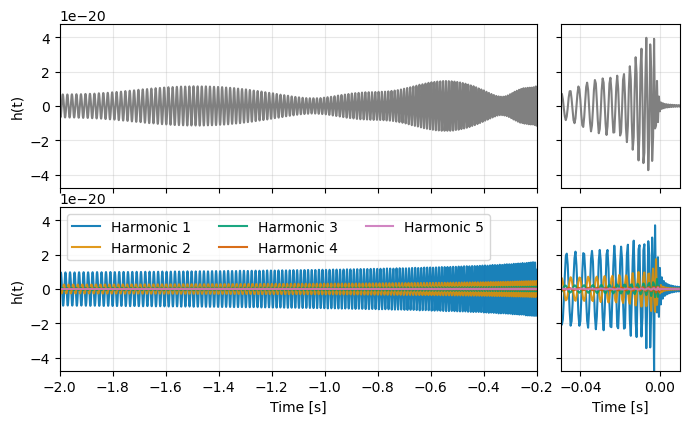

In [9]:
fig = plt.figure(figsize=(8, 4.5))
gs = GridSpec(nrows=2, ncols=2, width_ratios=[4,1])
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

axs = [ax0, ax1, ax2, ax3]
axs[0].plot(prec.sample_times, prec, color='grey')
axs[1].plot(prec.sample_times, prec, color='grey')

for ii in range(5):
    h = harmonics[ii].to_timeseries()
    h._epoch = 0.
    h = h.cyclic_time_shift(3.)
    axs[2].plot(h.sample_times, h, color=harmonic_colors[ii], label=f"Harmonic {ii + 1}", alpha=0.9)
    axs[3].plot(h.sample_times, h, color=harmonic_colors[ii], label=f"Harmonic {ii + 1}", alpha=0.9)

axs[0].set_xlim([-2, -0.2])
axs[0].set_xticklabels([])
axs[1].set_xlim([-0.05, 0.01])
axs[1].set_xticks([-0.04, 0.0])
axs[1].set_xticklabels([])
axs[2].set_xlim([-2, -0.2])
axs[1].set_xlim([-0.05, 0.01])
axs[3].set_xticks([-0.04, 0.0])
axs[3].set_xlim([-0.05, 0.01])
axs[1].set_yticklabels([])
axs[3].set_yticklabels([])
axs[0].set_ylabel("h(t)")
axs[2].set_ylabel("h(t)")
axs[2].set_xlabel(r"Time [s]")
axs[3].set_xlabel(r"Time [s]")
for ax in axs:
    ax.set_ylim([-4.75e-20, 4.75e-20])
axs[2].legend(loc="upper left", ncol=3)
axs[0].grid(alpha=0.3)
axs[1].grid(alpha=0.3)
axs[2].grid(alpha=0.3)
axs[3].grid(alpha=0.3)
plt.subplots_adjust(wspace=0.08, hspace=0.12)
plt.savefig("harmonics.pdf", format="pdf")

## Figure 4

In [6]:
sample_rate = 2048.
f_lower = 20.
df = 1. / 64.

m1, m2 = 10., 1.5
chi_1, chi_2 = 0.3, 0.3
chi_p0 = 0.1
chi_p1 = 0.3
chi_p2 = 0.6
chi_p3 = 0.9

template_gen0 = PhenomXPTemplateAlt(m1, m2, chi_p0, 0., chi_1, 0., 0., chi_2, sample_rate, f_lower)
template_gen1 = PhenomXPTemplateAlt(m1, m2, chi_p1, 0., chi_1, 0., 0., chi_2, sample_rate, f_lower)
template_gen2 = PhenomXPTemplateAlt(m1, m2, chi_p2, 0., chi_1, 0., 0., chi_2, sample_rate, f_lower)
template_gen3 = PhenomXPTemplateAlt(m1, m2, chi_p3, 0., chi_1, 0., 0., chi_2, sample_rate, f_lower)

In [7]:
psd = aLIGOZeroDetHighPower(int(2048. / df), df, 20.)
asd = psd ** 0.5

In [8]:
comps0 = template_gen0.get_whitened_normalized_comps(df, psd, num_comps=5)
comps0 = [
    FrequencySeries(c.data.data[:], delta_f=df, epoch=c.epoch)
    for c in comps0
]

comps1 = template_gen1.get_whitened_normalized_comps(df, psd, num_comps=5)
comps1 = [
    FrequencySeries(c.data.data[:], delta_f=df, epoch=c.epoch)
    for c in comps1
]

comps2 = template_gen2.get_whitened_normalized_comps(df, psd, num_comps=5)
comps2 = [
    FrequencySeries(c.data.data[:], delta_f=df, epoch=c.epoch)
    for c in comps2
]

comps3 = template_gen3.get_whitened_normalized_comps(df, psd, num_comps=5)
comps3 = [
    FrequencySeries(c.data.data[:], delta_f=df, epoch=c.epoch)
    for c in comps3
]

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/pycbc/types/array.py:217: RuntimeWarning: divide by zero encountered in true_divide
  ret = getattr(ufunc, method)(*inputs, **kwargs)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/pycbc/types/array.py:217: RuntimeWarning: invalid value encountered in true_divide
  ret = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
num = 1000
thetajn = np.arccos(np.random.uniform(-1., 1., size=num))
alpha0 = np.random.uniform(0, 2 * np.pi, size=num)
phi0 = np.random.uniform(0, 2 * np.pi, size=num)

theta = np.arccos(np.random.uniform(-1., 1., size=num))
phi = np.random.uniform(0, 2 * np.pi, size=num)
psi = np.random.uniform(0, 2 * np.pi, size=num)

overlaps = [
    np.zeros((num, 5), dtype=np.complex64),
    np.zeros((num, 5), dtype=np.complex64),
    np.zeros((num, 5), dtype=np.complex64),
    np.zeros((num, 5), dtype=np.complex64)
]
comps = [comps0, comps1, comps2, comps3]

# for i in tqdm.tqdm(range(num)):
for i in range(num):
    for j, template in enumerate([template_gen0, template_gen1, template_gen2, template_gen3]):
        hp, hc = template.gen_hp_hc(thetajn[i], alpha0[i], phi0[0], df, sample_rate / 2.)
        hp = FrequencySeries(hp.data.data[:], delta_f=df, epoch=hp.epoch)
        hc = FrequencySeries(hc.data.data[:], delta_f=df, epoch=hc.epoch)
        h = project_hplus_hcross(hp, hc, theta[i], phi[i], psi[i])
        h /= asd[:len(h)]
        h[:int(f_lower / df)] = 0.
        h[int(sample_rate / 2. / df):len(h)] = 0.

        sigmasq = h.inner(h).real * 4. * df
        h /= sigmasq ** 0.5

        for k in range(5):
            overlaps[j][i, k] = comps[j][k].inner(h) * 4. * df

  0%|          | 0/1000 [00:00<?, ?it/s]/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/pycbc/types/array.py:396: RuntimeWarning: invalid value encountered in true_divide
  self._data /= other
100%|██████████| 1000/1000 [01:58<00:00,  8.43it/s]


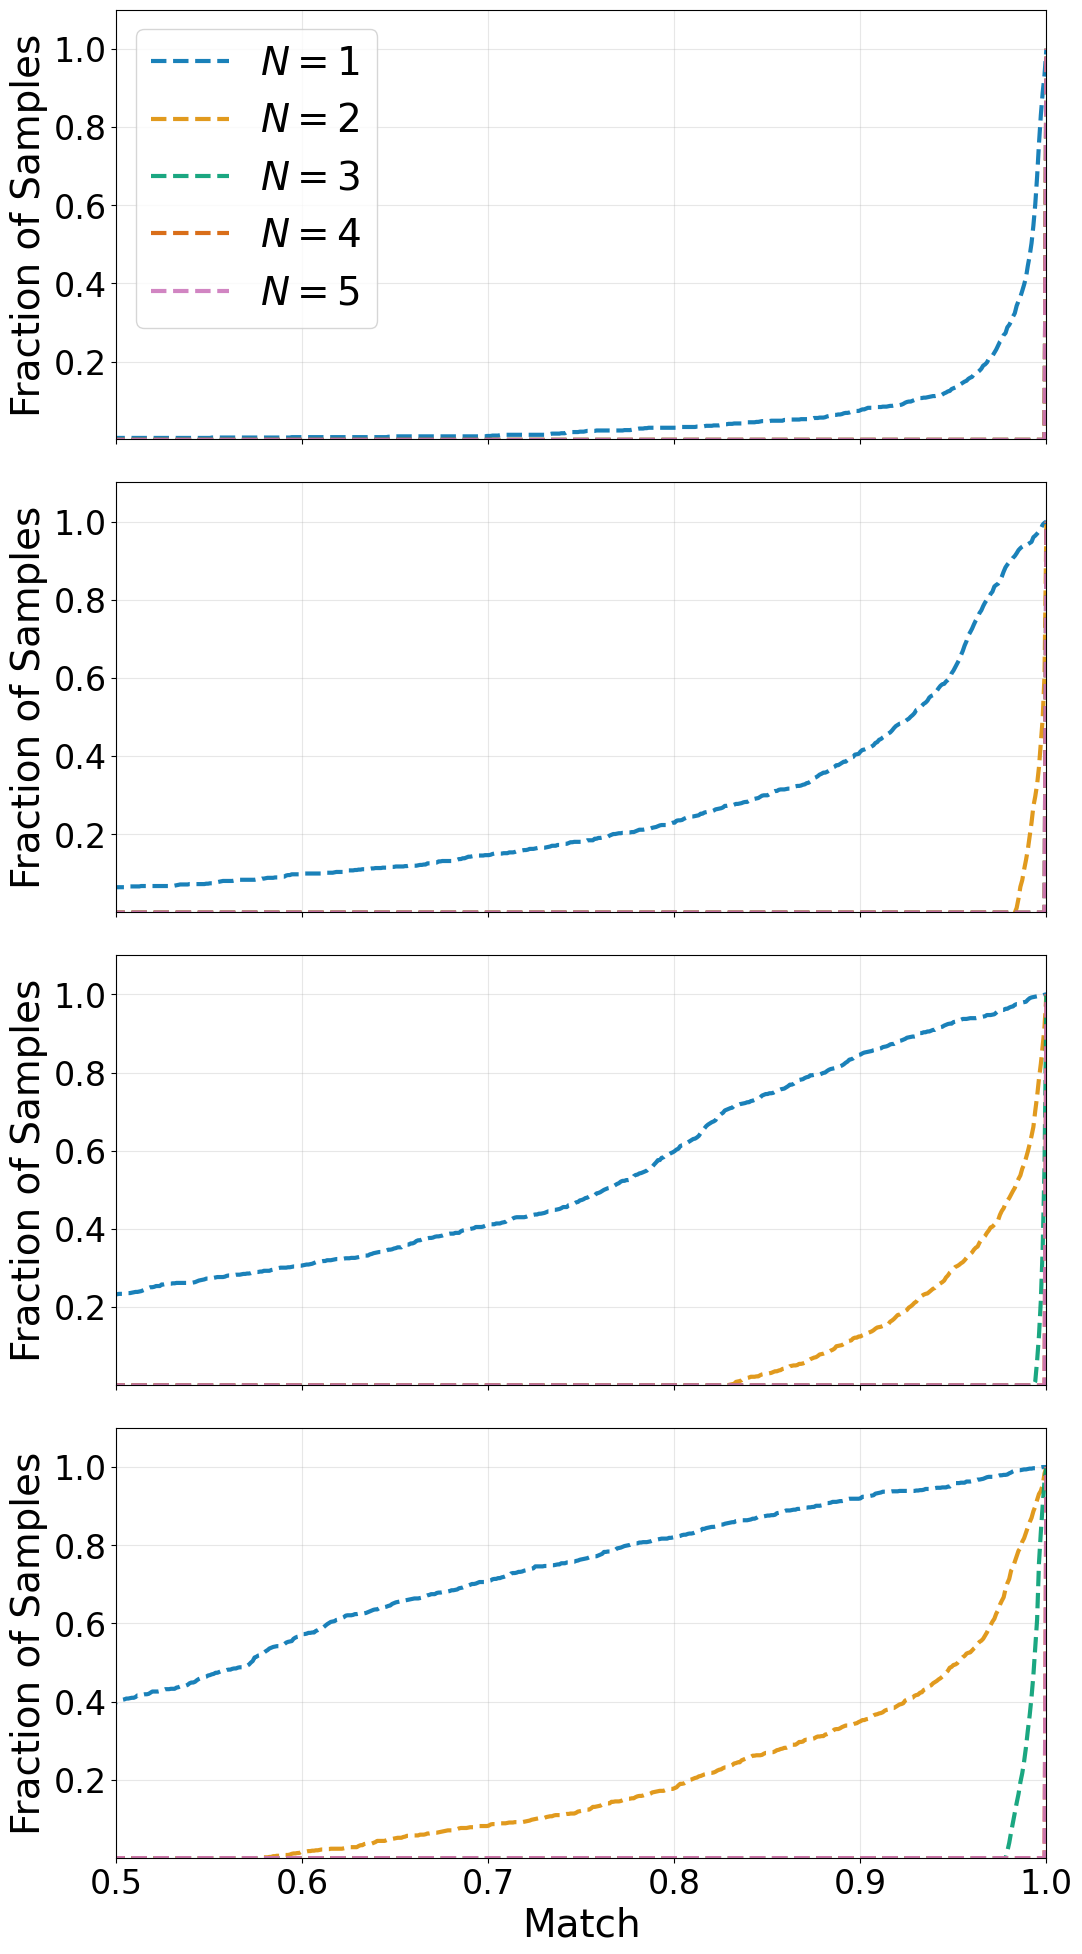

In [10]:
overlaps0, overlaps1, overlaps2, overlaps3 = overlaps
matches0 = np.cumsum(np.abs(overlaps0) ** 2., axis=1)
matches1 = np.cumsum(np.abs(overlaps1) ** 2., axis=1)
matches2 = np.cumsum(np.abs(overlaps2) ** 2., axis=1)
matches3 = np.cumsum(np.abs(overlaps3) ** 2., axis=1)

fig, ax = plt.subplots(nrows=4, figsize=[12, 24], sharex=True)

min_match = np.min([matches0.min(), matches1.min(), matches2.min(), matches3.min()])
bins = np.linspace(min_match, 1., num=1000, endpoint=True)

hist01, _ = np.histogram(matches0[:, 0], bins=bins, density=True)
hist02, _ = np.histogram(matches0[:, 1], bins=bins, density=True)
hist03, _ = np.histogram(matches0[:, 2], bins=bins, density=True)
hist04, _ = np.histogram(matches0[:, 3], bins=bins, density=True)
hist05, _ = np.histogram(matches0[:, 4], bins=bins, density=True)

hist11, _ = np.histogram(matches1[:, 0], bins=bins, density=True)
hist12, _ = np.histogram(matches1[:, 1], bins=bins, density=True)
hist13, _ = np.histogram(matches1[:, 2], bins=bins, density=True)
hist14, _ = np.histogram(matches1[:, 3], bins=bins, density=True)
hist15, _ = np.histogram(matches1[:, 4], bins=bins, density=True)

hist21, _ = np.histogram(matches2[:, 0], bins=bins, density=True)
hist22, _ = np.histogram(matches2[:, 1], bins=bins, density=True)
hist23, _ = np.histogram(matches2[:, 2], bins=bins, density=True)
hist24, _ = np.histogram(matches2[:, 3], bins=bins, density=True)
hist25, _ = np.histogram(matches2[:, 4], bins=bins, density=True)

hist31, _ = np.histogram(matches3[:, 0], bins=bins, density=True)
hist32, _ = np.histogram(matches3[:, 1], bins=bins, density=True)
hist33, _ = np.histogram(matches3[:, 2], bins=bins, density=True)
hist34, _ = np.histogram(matches3[:, 3], bins=bins, density=True)
hist35, _ = np.histogram(matches3[:, 4], bins=bins, density=True)

ax[0].plot(bins[1:], hist01.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[0], alpha=0.9, label=r'$N = 1$')
ax[0].plot(bins[1:], hist02.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[1], alpha=0.9, label=r'$N = 2$')
ax[0].plot(bins[1:], hist03.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[2], alpha=0.9, label=r'$N = 3$')
ax[0].plot(bins[1:], hist04.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[3], alpha=0.9, label=r'$N = 4$')
ax[0].plot(bins[1:], hist05.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[4], alpha=0.9, label=r'$N = 5$')

ax[1].plot(bins[1:], hist11.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[0], alpha=0.9, label=r'$N = 1$')
ax[1].plot(bins[1:], hist12.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[1], alpha=0.9, label=r'$N = 2$')
ax[1].plot(bins[1:], hist13.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[2], alpha=0.9, label=r'$N = 3$')
ax[1].plot(bins[1:], hist14.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[3], alpha=0.9, label=r'$N = 4$')
ax[1].plot(bins[1:], hist15.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[4], alpha=0.9, label=r'$N = 5$')

ax[2].plot(bins[1:], hist21.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[0], alpha=0.9, label=r'$N = 1$')
ax[2].plot(bins[1:], hist22.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[1], alpha=0.9, label=r'$N = 2$')
ax[2].plot(bins[1:], hist23.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[2], alpha=0.9, label=r'$N = 3$')
ax[2].plot(bins[1:], hist24.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[3], alpha=0.9, label=r'$N = 4$')
ax[2].plot(bins[1:], hist25.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[4], alpha=0.9, label=r'$N = 5$')

ax[-1].plot(bins[1:], hist31.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[0], alpha=0.9, label=r'$N = 1$')
ax[-1].plot(bins[1:], hist32.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[1], alpha=0.9, label=r'$N = 2$')
ax[-1].plot(bins[1:], hist33.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[2], alpha=0.9, label=r'$N = 3$')
ax[-1].plot(bins[1:], hist34.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[3], alpha=0.9, label=r'$N = 4$')
ax[-1].plot(bins[1:], hist35.cumsum() * (bins[1] - bins[0]), linewidth=3., linestyle="--", c=harmonic_colors[4], alpha=0.9, label=r'$N = 5$')

#ax.set_yscale('log')
ax[0].set_xlim((0.5, 1.))
ax[0].set_ylim((1e-3, 1.1))
ax[0].legend(loc='upper left', fontsize=28.)
#ax[0].set_xlabel('Match', fontsize=24.)
ax[0].set_ylabel('Fraction of Samples', fontsize=28.)
ax[0].tick_params(labelsize=24)
ax[0].grid(alpha=0.3)

ax[1].set_xlim((0.5, 1.))
ax[1].set_ylim((1e-3, 1.1))
#ax[1].legend(loc='upper left', fontsize=16.)
#ax[1].set_xlabel('Match', fontsize=24.)
ax[1].set_ylabel('Fraction of Samples', fontsize=28.)
ax[1].tick_params(labelsize=24)
ax[1].grid(alpha=0.3)

ax[2].set_xlim((0.5, 1.))
ax[2].set_ylim((1e-3, 1.1))
#ax[2].legend(loc='upper left', fontsize=16.)
#ax[2].set_xlabel('Match', fontsize=24.)
ax[2].set_ylabel('Fraction of Samples', fontsize=28.)
ax[2].tick_params(labelsize=24)
ax[2].grid(alpha=0.3)

ax[-1].set_xlim((0.5, 1.))
ax[-1].set_ylim((1e-3, 1.1))
#ax[-1].legend(loc='upper left', fontsize=16.)
ax[-1].set_xlabel('Match', fontsize=28.)
ax[-1].set_ylabel('Fraction of Samples', fontsize=28.)
ax[-1].tick_params(labelsize=24)
ax[-1].grid(alpha=0.3)

plt.subplots_adjust(hspace=.1)
fig.savefig('overlaps.pdf', bbox_inches='tight')

## Figure 5

Figure 5 requires some input data files. Please see

https://icg-gravwaves.github.io/precessing_search_paper/Figure5_data

for details on how to produce these if wanting to reproduce this plot.

In [48]:
m1 = []
chip = []
overlaps = []
sigmas = []

for i in range(1000):
    with h5py.File(f'/home/ian.harry/FILES_FOR_PAPER/overlaps/overlaps_{i}.hdf', 'r') as f:
        m1 += [f['m1'][:]]
        chip += [f['chip'][:]]
        overlaps += [f['overlaps'][:]]
        sigmas += [f['sigmas'][:]]
        
m1 = np.concatenate(m1, axis=0)
chip = np.concatenate(chip, axis=0)
overlaps = np.concatenate(overlaps, axis=0)
sigmas = np.concatenate(sigmas, axis=0)

In [49]:
match = np.cumsum(np.abs(overlaps) ** 2., axis=2)
above = match > 0.97
meff = np.sum(above, axis=1) / above.shape[1]

In [50]:
m1_2d = np.reshape(m1, (100, 100))
chip_2d = np.reshape(chip, (100, 100))
meff_c1_2d = np.reshape(meff[:, 0], (100, 100))
meff_c2_2d = np.reshape(meff[:, 1], (100, 100))
meff_c3_2d = np.reshape(meff[:, 2], (100, 100))
meff_c4_2d = np.reshape(meff[:, 3], (100, 100))
meff_c5_2d = np.reshape(meff[:, 4], (100, 100))

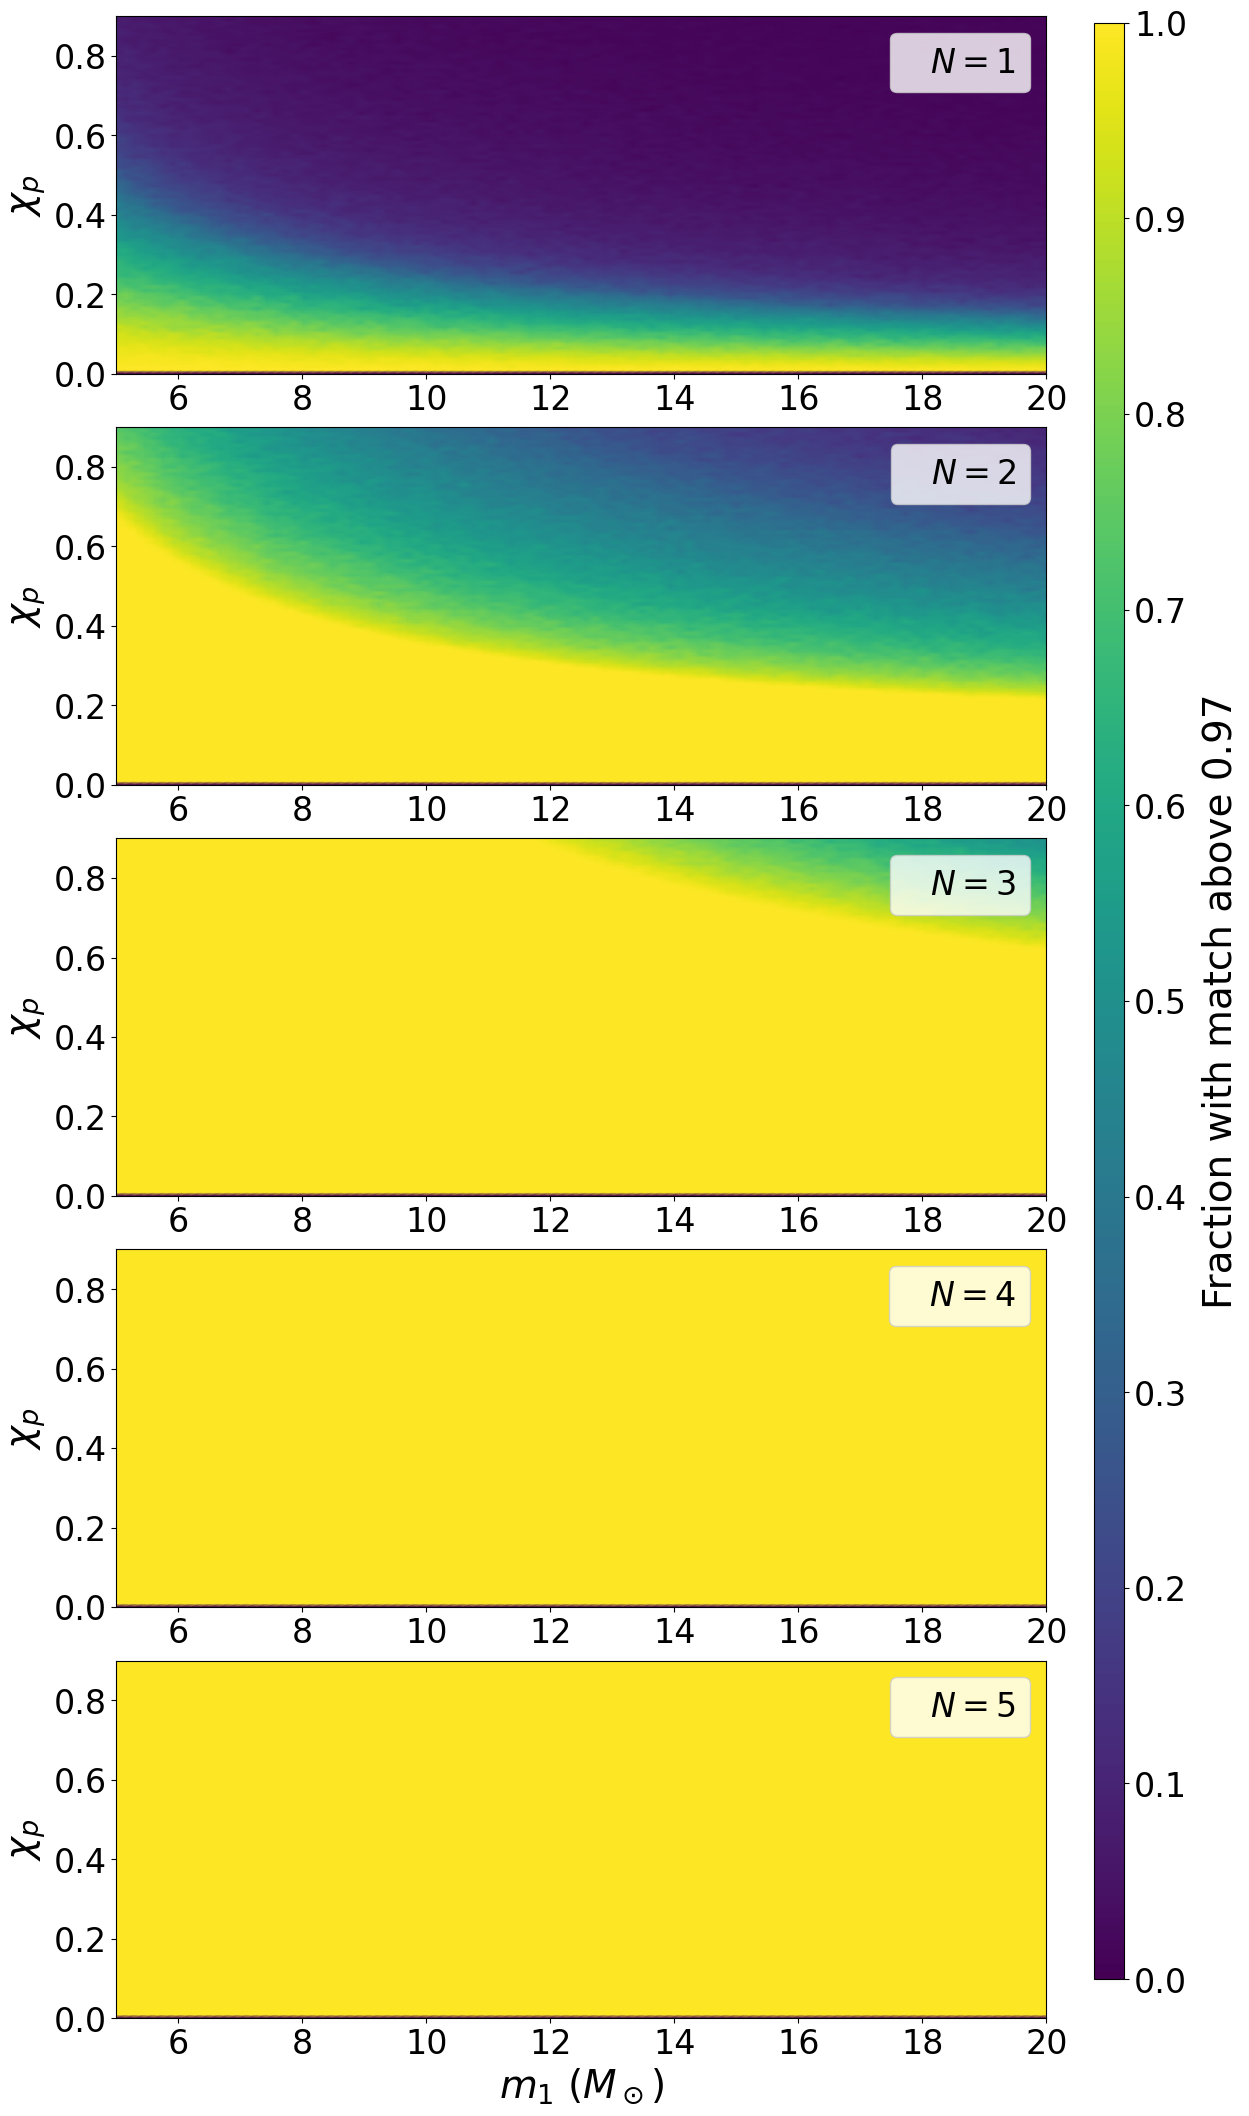

In [53]:
fig, ax = plt.subplots(nrows=5, figsize=[12, 26])
#fig, ax = plt.subplots(nrows=3, figsize=[12, 16])


mesh1 = ax[0].pcolormesh(m1_2d, chip_2d, meff_c1_2d, vmin=0., vmax=1., cmap='viridis', shading='gouraud')
mesh2 = ax[1].pcolormesh(m1_2d, chip_2d, meff_c2_2d, vmin=0., vmax=1., cmap='viridis', shading='gouraud')
mesh3 = ax[2].pcolormesh(m1_2d, chip_2d, meff_c3_2d, vmin=0., vmax=1., cmap='viridis', shading='gouraud')
mesh4 = ax[3].pcolormesh(m1_2d, chip_2d, meff_c4_2d, vmin=0., vmax=1., cmap='viridis', shading='gouraud')
mesh5 = ax[4].pcolormesh(m1_2d, chip_2d, meff_c5_2d, vmin=0., vmax=1., cmap='viridis', shading='gouraud')

#ax[0].set_xlabel('$m_{1}$ ($M_\odot$)', fontsize=28.)
handles = [Line2D([0], [0])]
ax[0].legend(handles, [r'$N = 1$'], handlelength=0, fontsize=24.)
ax[0].set_ylabel('$\chi_{p}$', fontsize=28.)
ax[0].tick_params(labelsize=24)

#ax[1].set_xlabel('$m_{1}$ ($M_\odot$)', fontsize=28.)
ax[1].legend(handles, [r'$N = 2$'], handlelength=0, fontsize=24.)
ax[1].set_ylabel('$\chi_{p}$', fontsize=28.)
ax[1].tick_params(labelsize=24)

#ax[2].set_xlabel('$m_{1}$ ($M_\odot$)', fontsize=28.)
ax[2].legend(handles, [r'$N = 3$'], handlelength=0, fontsize=24.)
ax[2].set_ylabel('$\chi_{p}$', fontsize=28.)
ax[2].tick_params(labelsize=24)

#ax[3].set_xlabel('$m_{1}$ ($M_\odot$)', fontsize=28.)
ax[3].legend(handles, [r'$N = 4$'], handlelength=0, fontsize=24.)
ax[3].set_ylabel('$\chi_{p}$', fontsize=28.)
ax[3].tick_params(labelsize=24)

ax[4].set_xlabel('$m_{1}$ ($M_\odot$)', fontsize=28.)
ax[4].legend(handles, [r'$N = 5$'], handlelength=0, fontsize=24.)
ax[4].set_ylabel('$\chi_{p}$', fontsize=28.)
ax[4].tick_params(labelsize=24)

cax = plt.axes([0.94, 0.125, 0.025, 0.7525])
cbar = fig.colorbar(mesh1, cax=cax, ticks=np.arange(0, 1.1, 0.1))
#cbar.set_label('$m_{eff}$', labelpad=1., fontsize=24.)
cbar.set_label('Fraction with match above 0.97', labelpad=10., fontsize=28.)
cbar.ax.tick_params(labelsize=24)

#cbar1 = fig.colorbar(mesh1, ax=ax[0])
#cbar2 = fig.colorbar(mesh2, ax=ax[1])
#cbar3 = fig.colorbar(mesh3, ax=ax[2])

#cbar1.set_label('$m_{eff}$', labelpad=1., fontsize=24.)
#cbar2.set_label('$m_{eff}$', labelpad=1., fontsize=24.)
#cbar3.set_label('$m_{eff}$', labelpad=1., fontsize=24.)

#cbar1.ax.tick_params(labelsize=16)
#cbar2.ax.tick_params(labelsize=16)
#cbar3.ax.tick_params(labelsize=16)

plt.subplots_adjust(hspace=.15)
fig.savefig('fraction_match.pdf', bbox_inches='tight')

## Figure 6

In [13]:
with h5py.File(precession_bank, 'r') as f:
    num_comps = f['num_comps'][:]
    mass1 = f['mass1'][:]
    mass2 = f['mass2'][:]
    mass = mass1 + mass2
    a1 = 2 + (3 * mass2) / (2 * mass1)
    a2 = 2 + (3 * mass1) / (2 * mass2)
    s1p = (f['spin1x'][:] ** 2. + f['spin1y'][:] ** 2.) ** 0.5
    s2p = (f['spin2x'][:] ** 2. + f['spin2y'][:] ** 2.) ** 0.5
    chip = 1 / (a1 * mass1 ** 2.) * np.maximum(a1 * s1p * mass1 ** 2., a2 * s2p * mass2 ** 2.)
    print(chip.min(), chip.max())

0.00017546969 0.9898638


In [14]:
labels = [r'$N = 1$', r'$N = 2$', r'$N = 3$', r'$N = 4$', r'$N = 5$']
values = [
    np.sum(num_comps == 1), np.sum(num_comps == 2), np.sum(num_comps == 3), np.sum(num_comps == 4),
    np.sum(num_comps >= 5)
]

n = 5
mass_bins = np.linspace(11.2, 21.7, num=n+1, endpoint=True)
chip_bins = np.linspace(0., 1., num=n+1, endpoint=True)

mass_mesh = np.zeros((n, n), dtype=np.float32)
chip_mesh = np.zeros((n, n), dtype=np.float32)

average_n = np.zeros((n, n), dtype=np.float32)

for i in range(len(mass_bins) - 1):
    mlow = mass_bins[i]
    mhigh = mass_bins[i+1]
    for j in range(len(chip_bins) - 1):
        clow = chip_bins[j]
        chigh = chip_bins[j+1]
    
        lgc = (mass > mlow) & (mass <= mhigh) & (chip > clow) & (chip <= chigh)
        average_n[j, i] = np.mean(num_comps[lgc])
            
        mass_mesh[j, i] = (mlow + mhigh) / 2.
        chip_mesh[j, i] = (clow + chigh) / 2.

In [15]:
# These files are available from our data release page
with h5py.File(f"{aligned_dir}/ALIGNED_BANKSIM.h5", 'r') as f:
    aligned_match = f['/trig_params/match'][:]
    
with h5py.File(f"{precession_dir}/PRECESSING_BANKSIM.h5", 'r') as f:
    prec_match_comp1 = f['/trig_params_1/match'][:]
    prec_match_comp2 = f['/trig_params_2/match'][:]
    prec_match_comp3 = f['/trig_params_3/match'][:]
    prec_match_comp4 = f['/trig_params_4/match'][:]
    prec_match_comp5 = f['/trig_params_5/match'][:]
    prec_match_vary2 = f['/trig_params_vary_max2/match'][:]
    prec_match_vary3 = f['/trig_params_vary_max3/match'][:]
    prec_match_vary4 = f['/trig_params_vary_max4/match'][:]
    prec_match_vary5 = f['/trig_params_vary/match'][:]
    
bins = np.linspace(aligned_match.min(), 1., num=10000, endpoint=True)
hista, _ = np.histogram(aligned_match, bins=bins, density=True)
hist1, _ = np.histogram(prec_match_comp1, bins=bins, density=True)
hist2v, _ = np.histogram(prec_match_vary2, bins=bins, density=True)
hist2, _ = np.histogram(prec_match_comp2, bins=bins, density=True)
hist3v, _ = np.histogram(prec_match_vary3, bins=bins, density=True)
hist3, _ = np.histogram(prec_match_comp3, bins=bins, density=True)
hist4v, _ = np.histogram(prec_match_vary4, bins=bins, density=True)
hist4, _ = np.histogram(prec_match_comp4, bins=bins, density=True)
hist5v, _ = np.histogram(prec_match_vary5, bins=bins, density=True)
hist5, _ = np.histogram(prec_match_comp5, bins=bins, density=True)

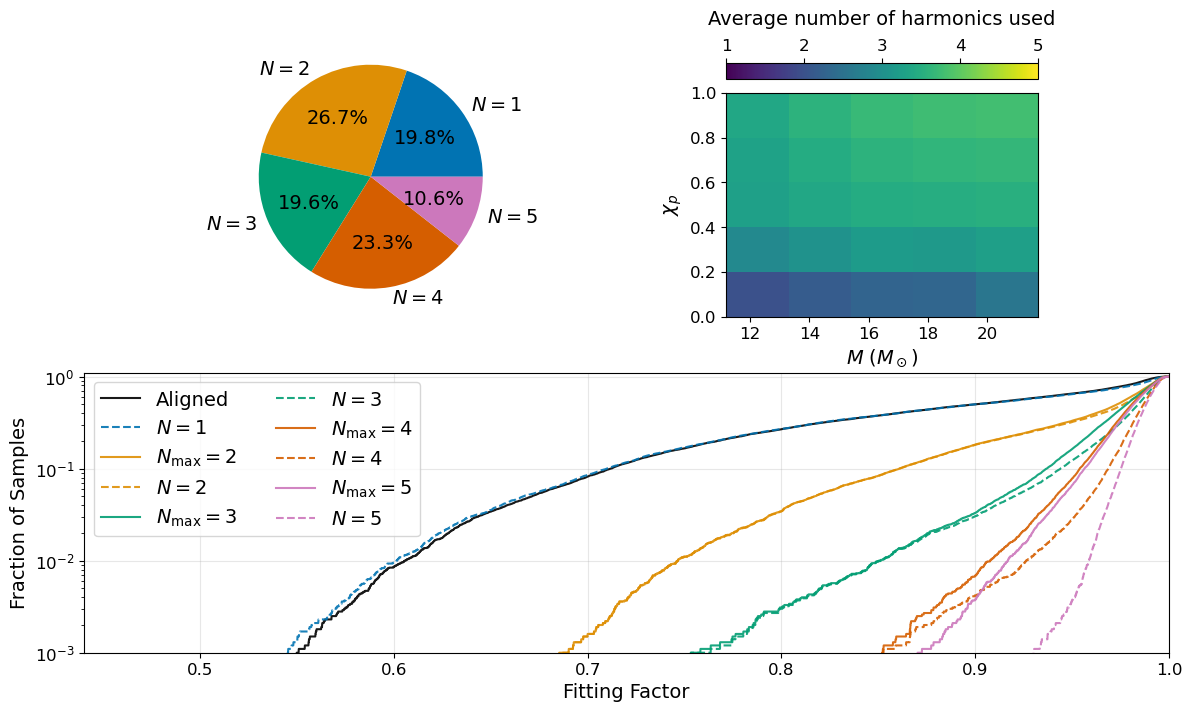

In [16]:
gs = GridSpec(nrows=2, ncols=5, width_ratios=[1, 14, 2, 10, 3])
fig = plt.figure(figsize=(14, 8))
axs = [fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,3]), fig.add_subplot(gs[1, :])]

axs[0].pie(values, labels=labels, autopct='%1.1f%%', colors=harmonic_colors[:5],
          textprops={'fontsize': 14.})

mesh = axs[1].pcolormesh(mass_mesh, chip_mesh, average_n, vmin=1, vmax=5, cmap='viridis')

axs[1].set_xlabel('$M$ ($M_\odot$)', fontsize=14.)
axs[1].set_ylabel('$\chi_{p}$', fontsize=14.)
axs[1].tick_params(labelsize=12)
cbar1 = fig.colorbar(mesh, ax=axs[1], location='top')
cbar1.set_label('Average number of harmonics used', labelpad=10., fontsize=14.)
cbar1.ax.tick_params(labelsize=12)

axs[2].plot(bins[1:], hista.cumsum() * (bins[1] - bins[0]), c='k', alpha=0.9, label='Aligned')
axs[2].plot(bins[1:], hist1.cumsum() * (bins[1] - bins[0]), c=harmonic_colors[0], linestyle='--', alpha=0.9, label=r'$N = 1$')
axs[2].plot(bins[1:], hist2v.cumsum() * (bins[1] - bins[0]), c=harmonic_colors[1], alpha=0.9, label=r'$N_{\mathrm{max}} = 2$')
axs[2].plot(bins[1:], hist2.cumsum() * (bins[1] - bins[0]), c=harmonic_colors[1], linestyle='--', alpha=0.9, label=r'$N = 2$')
axs[2].plot(bins[1:], hist3v.cumsum() * (bins[1] - bins[0]), c=harmonic_colors[2], alpha=0.9, label=r'$N_{\mathrm{max}} = 3$')
axs[2].plot(bins[1:], hist3.cumsum() * (bins[1] - bins[0]), c=harmonic_colors[2], linestyle='--', alpha=0.9, label=r'$N = 3$')
axs[2].plot(bins[1:], hist4v.cumsum() * (bins[1] - bins[0]), c=harmonic_colors[3], alpha=0.9, label=r'$N_{\mathrm{max}} = 4$')
axs[2].plot(bins[1:], hist4.cumsum() * (bins[1] - bins[0]), c=harmonic_colors[3], linestyle='--', alpha=0.9, label=r'$N = 4$')
axs[2].plot(bins[1:], hist5v.cumsum() * (bins[1] - bins[0]), c=harmonic_colors[4], alpha=0.9, label=r'$N_{\mathrm{max}} = 5$')
axs[2].plot(bins[1:], hist5.cumsum() * (bins[1] - bins[0]), c=harmonic_colors[4], linestyle='--', alpha=0.9, label=r'$N = 5$')

axs[2].set_yscale('log')
axs[2].set_xlim((0.44, 1.))
axs[2].set_ylim((1e-3, 1.1))
axs[2].legend(loc='upper left', fontsize=14., ncol=2)
axs[2].set_xlabel('Fitting Factor', fontsize=14.)
axs[2].set_ylabel('Fraction of Samples', fontsize=14.)
axs[2].tick_params(labelsize=12)
axs[2].grid(alpha=0.3)

plt.subplots_adjust(wspace=0.2, hspace=0.2)
fig.savefig('fitting_factor.pdf', bbox_inches='tight')

## Figure 7

In [6]:
def get_snr_chi(search_dir, ifo='H1'):
    # These are the large files that are hard to host
    _filename = ifo + "-HDF_TRIGGER_MERGE_FULL_DATA-1242484974-676544.hdf"
    sngl_file = search_dir + "/" + _filename
    coinc_file = search_dir + "/H1L1-COMBINE_STATMAP_FULL_DATA-1242484974-676544.hdf"
    _filename = ifo + "-HDF_TRIGGER_MERGE_NSBH_FULL_INJECTIONS-1242484974-676544.hdf"
    inj_file = search_dir + "/" + _filename
    injfind_file = search_dir + "/H1L1-HDFINJFIND_NSBH_FULL_INJECTIONS-1242484974-676544.hdf"
       
    with h5py.File(coinc_file, 'r') as f:
        bid = f[f'background_exc/{ifo}/trigger_id'][:]
        
    with h5py.File(sngl_file, 'r') as f:
        bsnr = f[f'{ifo}/snr'][:][bid]
        bchisq = f[f'{ifo}/chisq'][:][bid]
        dof = f[f'{ifo}/chisq_dof'][:][bid]
        bchisq /= (dof * 2 - 2)

    lgc = bchisq > 0.
    bsnr = bsnr[lgc]
    bchisq = bchisq[lgc]
    
    with h5py.File(injfind_file, 'r') as f:
        tid = f[f'found_after_vetoes/{ifo}/trigger_id'][:]
        inj_idx = f['found_after_vetoes/injection_index'][:]

        dist = f['injections/distance'][:][inj_idx]
        mass1 = f['injections/mass1'][:][inj_idx]
        mass2 = f['injections/mass2'][:][inj_idx]
        mass = mass1 + mass2
        a1 = 2 + (3 * mass2) / (2 * mass1)
        a2 = 2 + (3 * mass1) / (2 * mass2)
        s1p = (f['injections/spin1x'][:][inj_idx] ** 2. + f['injections/spin1y'][:][inj_idx] ** 2.) ** 0.5
        s2p = (f['injections/spin2x'][:][inj_idx] ** 2. + f['injections/spin2y'][:][inj_idx] ** 2.) ** 0.5
        chip = 1 / (a1 * mass1 ** 2.) * np.maximum(a1 * s1p * mass1 ** 2., a2 * s2p * mass2 ** 2.)

    with h5py.File(inj_file, 'r') as f:
        isnr = f[f'{ifo}/snr'][:][tid]
        ichisq = f[f'{ifo}/chisq'][:][tid]
        dof = f[f'{ifo}/chisq_dof'][:][tid]
        ichisq /= (dof * 2 - 2)

    lgc = ichisq > 0.
    isnr = isnr[lgc]
    ichisq = ichisq[lgc]

    return bsnr, bchisq, isnr, ichisq, chip

In [7]:
bsnr1, bchisq1, isnr1, ichisq1, chip1 = get_snr_chi(aligned_search, ifo='H1')
bsnr2, bchisq2, isnr2, ichisq2, chip2 = get_snr_chi(comp2_search, ifo='H1')
bsnr3, bchisq3, isnr3, ichisq3, chip3 = get_snr_chi(comp3_search, ifo='H1')

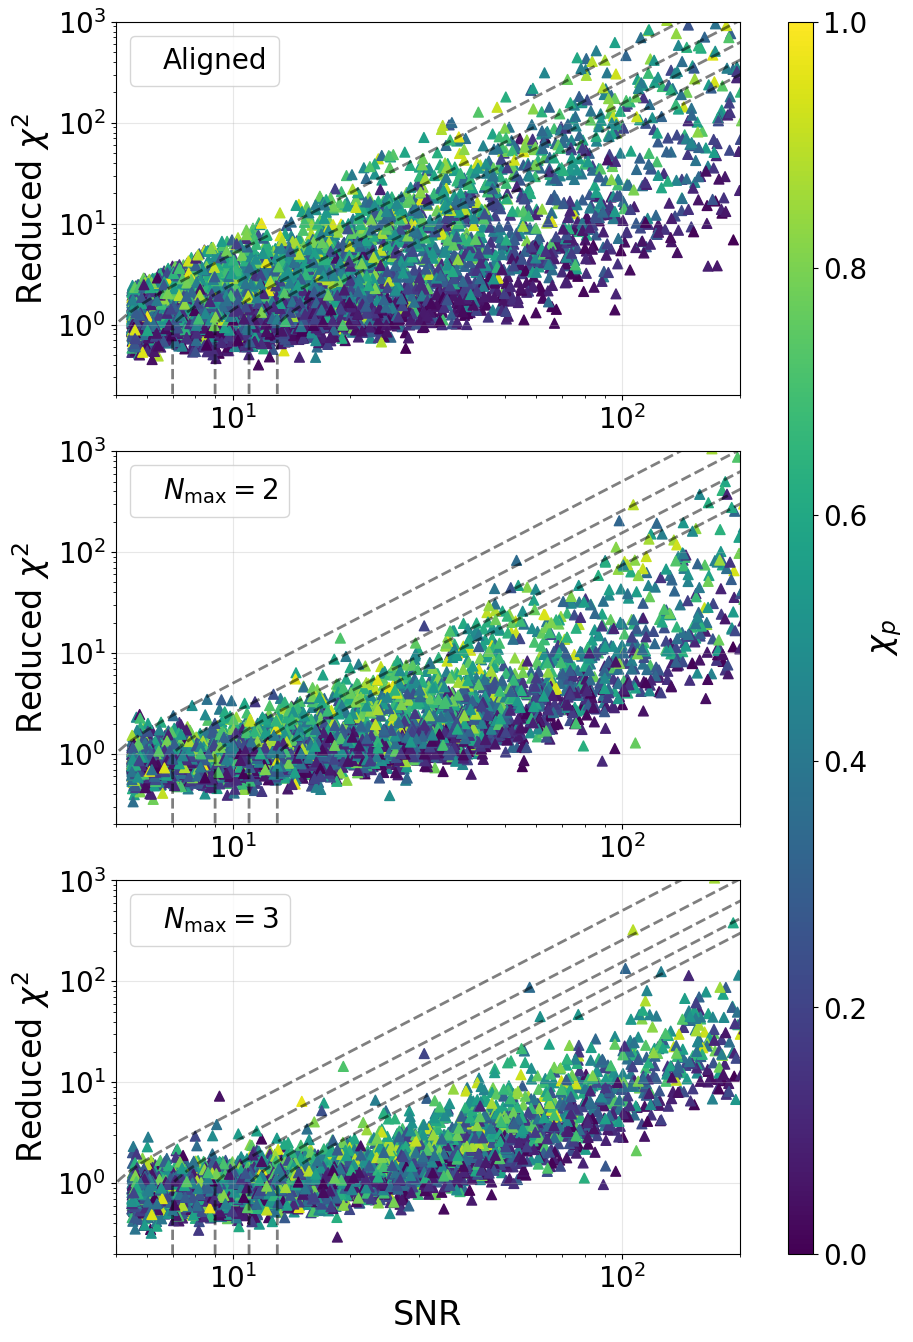

In [10]:
fig = plt.figure(figsize=(9, 16))
gs = GridSpec(nrows=3, ncols=2, width_ratios=[25, 1])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[2,0], sharex=ax2)
ax4 = fig.add_subplot(gs[:,1])
ax = [ax1, ax2, ax3, ax4]

chi_cont = np.logspace(-2, 4, 300)
for c in [5, 7, 9, 11, 13]:
    chisq_mod = (chi_cont ** 3. + 1.) / 2.
    chisq_mod = np.maximum(chisq_mod, np.ones_like(chisq_mod))
    snr_cont = c * (chisq_mod ** (1. / 6.))
    ax[0].plot(snr_cont, chi_cont, color='black', alpha=0.5, linestyle='--', linewidth=2.)
    ax[1].plot(snr_cont, chi_cont, color='black', alpha=0.5, linestyle='--', linewidth=2.)
    ax[2].plot(snr_cont, chi_cont, color='black', alpha=0.5, linestyle='--', linewidth=2.)
    
#sc1 = ax[0].scatter(bsnr1, bchisq1, c='black', s=20., marker='o', label='Noise', rasterized=True)
sc1 = ax[0].scatter(isnr1, ichisq1, s=50., marker='^', label='Signals', c=chip1, vmin=0., vmax=1., rasterized=True)
handles = [Line2D([0], [0])]
ax[0].legend(handles, ['Aligned'], handlelength=0, fontsize=20.)

#sc2 = ax[1].scatter(bsnr2, bchisq2, c='black', s=20., marker='o', label='Noise', rasterized=True)
sc2 = ax[1].scatter(isnr2, ichisq2, s=50., marker='^', label='Signals', c=chip2, vmin=0., vmax=1., rasterized=True)
ax[1].legend(handles, [r'$N_{\mathrm{max}} = 2$'], handlelength=0, fontsize=20.)

#sc3 = ax[2].scatter(bsnr3, bchisq3, c='black', s=20., marker='o', label='Noise', rasterized=True)
sc3 = ax[2].scatter(isnr3, ichisq3, s=50., marker='^', label='Signals', c=chip3, vmin=0., vmax=1., rasterized=True)
ax[2].legend(handles, [r'$N_{\mathrm{max}} = 3$'], handlelength=0, fontsize=20.)

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_yscale('log')


ax[0].set_ylim((0.2, 1000.))
ax[1].set_ylim((0.2, 1000.))
ax[2].set_ylim((0.2, 1000.))
ax[2].set_xlim((5., 200.))

ax[0].set_ylabel('Reduced $\chi^2$', fontsize=24.)
ax[0].tick_params(labelsize=20)
ax[0].grid(alpha=0.3)
ax[1].set_ylabel('Reduced $\chi^2$', fontsize=24.)
ax[1].tick_params(labelsize=20)
ax[1].grid(alpha=0.3)
ax[2].set_xlabel('SNR', fontsize=24.)
ax[2].set_ylabel('Reduced $\chi^2$', fontsize=24.)
ax[2].tick_params(labelsize=20)
ax[2].grid(alpha=0.3)

cbar = fig.colorbar(sc1, cax=ax[-1])
cbar.set_label('$\chi_{p}$', labelpad=2., fontsize=24.)
cbar.ax.tick_params(labelsize=20)
plt.subplots_adjust(hspace=0.15, wspace=0.15)
plt.savefig('harmonic_snr_chi.pdf', bbox_inches='tight', dpi=150)

## Figure 8

In [ ]:
# Also large files that are hard to host
bank_file = aligned_search + "/H1L1-BANK2HDF-1242484974-676544.hdf"
veto_file = aligned_search + "/H1L1-FOREGROUND_CENSOR-1242484974-676544.xml"
trig_file = aligned_search + "/L1-HDF_TRIGGER_MERGE_FULL_DATA-1242484974-676544.hdf"

trigs = SingleDetTriggers(trig_file, bank_file, veto_file, 'closed_box', 'self.snr > 6.', 'L1')
coinc_snr = getattr(trigs, 'snr')
coinc_new = getattr(trigs, 'newsnr_sgveto')

In [ ]:
bank_file = comp2_search + "/H1L1-BANK2HDF-1242484974-676544.hdf"
veto_file = comp2_search + "/H1L1-FOREGROUND_CENSOR-1242484974-676544.xml"
trig_file = comp2_search + "/L1-HDF_TRIGGER_MERGE_FULL_DATA-1242484974-676544.hdf"

trigs = SingleDetTriggers(trig_file, bank_file, veto_file, 'closed_box', 'self.snr > 6.', 'L1')
prec2_snr = getattr(trigs, 'snr')
prec2_new = getattr(trigs, 'newsnr_sgveto')

In [ ]:
bank_file = comp3_search + "/H1L1-BANK2HDF-1242484974-676544.hdf"
veto_file = comp3_search + "/H1L1-FOREGROUND_CENSOR-1242484974-676544.xml"
trig_file = comp3_search + "/L1-HDF_TRIGGER_MERGE_FULL_DATA-1242484974-676544.hdf"

trigs = SingleDetTriggers(trig_file, bank_file, veto_file, 'closed_box', 'self.snr > 6.', 'L1')
prec3_snr = getattr(trigs, 'snr')
prec3_new = getattr(trigs, 'newsnr_sgveto')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
bins = np.linspace(0, 200, 10000, endpoint=True)

coinc_snr_hist, _ = np.histogram(coinc_snr, bins=bins)
coinc_new_hist, _ = np.histogram(coinc_new, bins=bins)
    
coinc_snr_cumnum = np.cumsum(coinc_snr_hist[::-1])[::-1]
coinc_new_cumnum = np.cumsum(coinc_new_hist[::-1])[::-1]

prec2_snr_hist, _ = np.histogram(prec2_snr, bins=bins)
prec2_new_hist, _ = np.histogram(prec2_new, bins=bins)
    
prec2_snr_cumnum = np.cumsum(prec2_snr_hist[::-1])[::-1]
prec2_new_cumnum = np.cumsum(prec2_new_hist[::-1])[::-1]

prec3_snr_hist, _ = np.histogram(prec3_snr, bins=bins)
prec3_new_hist, _ = np.histogram(prec3_new, bins=bins)
    
prec3_snr_cumnum = np.cumsum(prec3_snr_hist[::-1])[::-1]
prec3_new_cumnum = np.cumsum(prec3_new_hist[::-1])[::-1]

xs = np.linspace(6, 20, 1000)
chi2 = 1. - scipy.special.gammainc(1, xs ** 2. / 2.)
chi6 = 1. - scipy.special.gammainc(3, xs ** 2. / 2.)

coinc_count = np.sum(coinc_new > 6.)
prec2_count = np.sum(prec2_new > 6.)
prec3_count = np.sum(prec3_new > 6.)

chi2_norm = coinc_count / (1. - scipy.special.gammainc(1, 6. ** 2. / 2.))
chi4_norm = prec2_count / (1. - scipy.special.gammainc(2, 6. ** 2. / 2.))
chi6_norm = prec3_count / (1. - scipy.special.gammainc(3, 6. ** 2. / 2.))

ax.loglog(bins[:-1], coinc_new_cumnum, alpha=0.9, label='Aligned',
          linewidth=2., color='k')
ax.loglog(bins[:-1], prec2_new_cumnum, alpha=0.9, label=r'$N_{\mathrm{max}} = 2$',
          linewidth=2., color=harmonic_colors[1])
#ax.loglog(bins[:-1], prec3_new_cumnum, alpha=0.9, label='$N_{\mathrm{max}} = 3$',
#          linewidth=2., color=harmonic_colors[2])

ax.set_ylabel('Number of Triggers Above', fontsize=24.)
ax.set_xlabel('Re-weighted SNR', fontsize=24.)
ax.set_ylim(ymin=1, ymax=2e8)
ax.set_xlim(xmin=6., xmax=11.)
ax.grid()
ax.legend(loc='upper right', fontsize=24)
ax.tick_params(which='both', labelsize=16)

plt.savefig('harmonic_hist.pdf', bbox_inches='tight')

## Figure 9

In [11]:
# These files are all available on our data release pages
files = {
    'aligned_coinc': '/home/ian.harry/FILES_FOR_PAPER/H1L1-HDFINJFIND_NSBH_FULL_ALIGNED_SNR_INJECTIONS-1242484974-676544.hdf',
    'aligned_phase': '/home/ian.harry/FILES_FOR_PAPER/H1L1-HDFINJFIND_NSBH_FULL_ALIGNED_RANKSTAT_INJECTIONS-1242484974-676544.hdf',
    'prec_c2_coinc': '/home/ian.harry/FILES_FOR_PAPER/H1L1-HDFINJFIND_NSBH_FULL_PREC2COMP_SNR_INJECTIONS-1242484974-676544.hdf',
    'prec_c2_phase': '/home/ian.harry/FILES_FOR_PAPER/H1L1-HDFINJFIND_NSBH_FULL_PREC2COMP_RANKSTAT_INJECTIONS-1242484974-676544.hdf',
    'prec_c3_coinc': '/home/ian.harry/FILES_FOR_PAPER/H1L1-HDFINJFIND_NSBH_FULL_PREC3COMP_SNR_INJECTIONS-1242484974-676544.hdf',
    'prec_c3_phase': '/home/ian.harry/FILES_FOR_PAPER/H1L1-HDFINJFIND_NSBH_FULL_PREC3COMP_RANKSTAT_INJECTIONS-1242484974-676544.hdf',
}

vols = {}
errs = {}

thresh = 100.
nmass = 3
nchip = 3

mass_bins = np.linspace(11.2, 21.7, num=nmass+1, endpoint=True)
chip_bins = np.linspace(0., 1., num=nchip+1, endpoint=True)

mass_mesh = np.zeros((nchip, nmass), dtype=np.float32)
chip_mesh = np.zeros((nchip, nmass), dtype=np.float32)

for k, v in files.items():
    
    with h5py.File(v, 'r') as f:

        found = f['found_after_vetoes/injection_index'][:]
        missed = f['missed/after_vetoes'][:]

        mass1 = f['injections/mass1'][:]
        mass2 = f['injections/mass2'][:]
        mass = mass1 + mass2
        a1 = 2 + (3 * mass2) / (2 * mass1)
        a2 = 2 + (3 * mass1) / (2 * mass2)
        s1p = (f['injections/spin1x'][:] ** 2. + f['injections/spin1y'][:] ** 2.) ** 0.5
        s2p = (f['injections/spin2x'][:] ** 2. + f['injections/spin2y'][:] ** 2.) ** 0.5
        chip = 1 / (a1 * mass1 ** 2.) * np.maximum(a1 * s1p * mass1 ** 2., a2 * s2p * mass2 ** 2.)
        print(chip.min(), chip.max())
        
        dist = f['injections/distance'][:]
        print(f"distance: {dist.min():.2f} -> {dist.max():.2f}")

        ifar_exc = f['found_after_vetoes/ifar_exc'][:]
        t = f.attrs['foreground_time_exc'] / lal_YRJUL_SI

    quiet = found[ifar_exc < thresh]
    missed = np.concatenate([missed, quiet])
    found = found[ifar_exc >= thresh]

    missed_dist = dist[missed]
    found_dist = dist[found]

    missed_mass = mass[missed]
    found_mass = mass[found]
    
    missed_chip = chip[missed]
    found_chip = chip[found]

    vol = np.zeros((nchip, nmass), dtype=np.float32)
    err = np.zeros((nchip, nmass), dtype=np.float32)

    for i in range(len(mass_bins) - 1):
        mlow = mass_bins[i]
        mhigh = mass_bins[i+1]
        for j in range(len(chip_bins) - 1):
            clow = chip_bins[j]
            chigh = chip_bins[j+1]
    
            missed_lgc = (missed_mass > mlow) & (missed_mass <= mhigh) & (missed_chip > clow) & (missed_chip <= chigh)
            found_lgc = (found_mass > mlow) & (found_mass <= mhigh) & (found_chip > clow) & (found_chip <= chigh)
    
            missed_dist_bin = missed_dist[missed_lgc]
            found_dist_bin = found_dist[found_lgc]
    
            v, e = volume_binned_pylal(found_dist_bin, missed_dist_bin, bins=50)
            vol[j, i] = v
            err[j, i] = e
            
            mass_mesh[j, i] = (mlow + mhigh) / 2.
            chip_mesh[j, i] = (clow + chigh) / 2.
    
    vols[k] = vol
    errs[k] = err

0.0007725729171931529 0.9894160260630762
distance: 1.68 -> 285.05
0.0007725729171931529 0.9894160260630762
distance: 1.68 -> 285.05
0.0007725729171931529 0.9894160260630762
distance: 1.68 -> 285.05
0.0007725729171931529 0.9894160260630762
distance: 1.68 -> 285.05
0.0007725729171931529 0.9894160260630762
distance: 1.68 -> 285.05
0.0007725729171931529 0.9894160260630762
distance: 1.68 -> 285.05


In [12]:
vmax = 150
vmin = -vmax

vmax_reduced = 30
vmin_reduced = -vmax_reduced

[[1.0994637 1.0372905 1.0788873]
 [1.3876009 1.4066858 1.7780114]
 [1.7622256 1.781097  2.1903028]] [[0.16666667 0.16666667 0.16666667]
 [0.5        0.5        0.5       ]
 [0.8333333  0.8333333  0.8333333 ]]
[[0.86619973 0.8646784  0.84913325]
 [1.062639   1.1656826  1.4719933 ]
 [1.5758059  1.4171075  1.6252705 ]] [[0.16666667 0.16666667 0.16666667]
 [0.5        0.5        0.5       ]
 [0.8333333  0.8333333  0.8333333 ]]
[[0.7878384  0.83359337 0.7870454 ]
 [0.7658103  0.82867295 0.8278875 ]
 [0.89421344 0.7956375  0.74203   ]] [[0.16666667 0.16666667 0.16666667]
 [0.5        0.5        0.5       ]
 [0.8333333  0.8333333  0.8333333 ]]


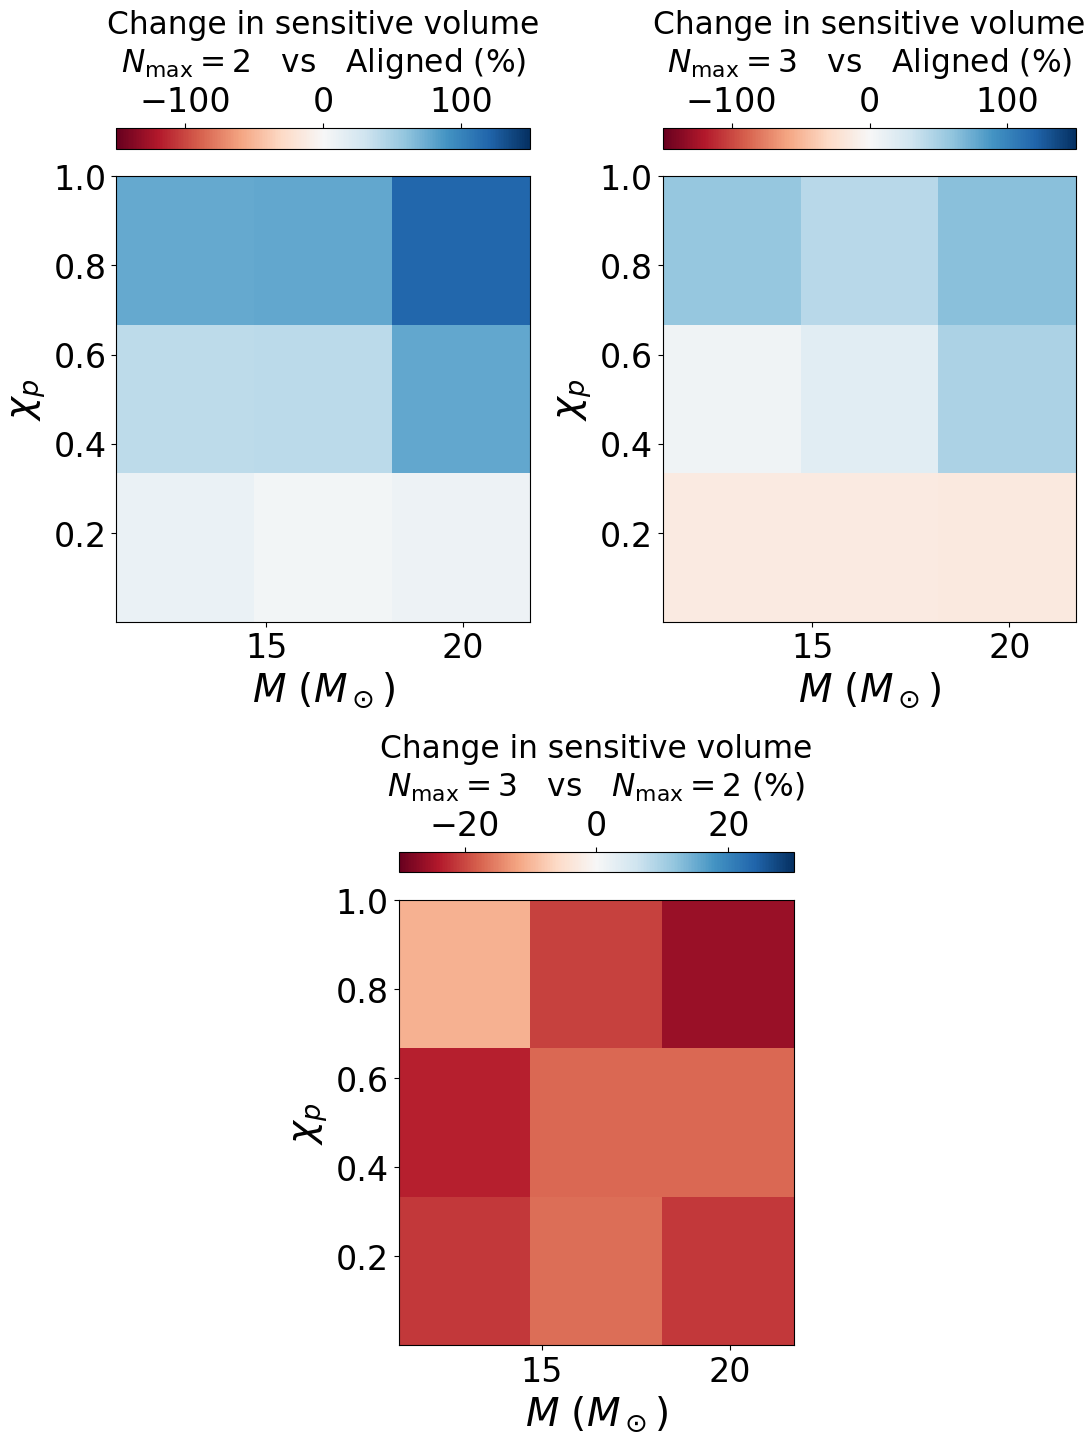

In [25]:
fig = plt.figure(figsize=(12., 16.))
gs = fig.add_gridspec(2, 1, width_ratios=[1.], height_ratios=[1., 1.],
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.32, hspace=0.3)

gst = gs[0].subgridspec(1, 2, width_ratios=[0.5, 0.5], height_ratios=[1.],
                        wspace=0.32, hspace=0.)
gsb = gs[1].subgridspec(1, 3, width_ratios=[0.25, 0.5, 0.25], height_ratios=[1.],
                        wspace=0.32, hspace=0.)

ax1 = fig.add_subplot(gst[0])
ax2 = fig.add_subplot(gst[1])
ax3 = fig.add_subplot(gsb[1])

vt_ratio = vols['prec_c2_coinc'] / vols['aligned_coinc']
print(vt_ratio, chip_mesh)
schange = (vt_ratio - 1) * 100
maxr = np.abs(schange).max()
if maxr > vmax:
    print(f"Warning: using vmax={vaxm} when max change is {maxr}")

mesh1 = ax1.pcolormesh(mass_mesh, chip_mesh, schange, vmin=vmin, vmax=vmax, cmap='RdBu')

vt_ratio = vols['prec_c3_coinc'] / vols['aligned_coinc']
print(vt_ratio, chip_mesh)
schange = (vt_ratio - 1) * 100
maxr = np.abs(schange).max()
if maxr > vmax:
    print(f"Warning: using vmax={vmax} when max change is {maxr}")
mesh2 = ax2.pcolormesh(mass_mesh, chip_mesh, schange, vmin=vmin, vmax=vmax, cmap='RdBu')

vt_ratio = vols['prec_c3_coinc'] / vols['prec_c2_coinc']
print(vt_ratio, chip_mesh)
schange = (vt_ratio - 1) * 100
maxr = np.abs(schange).max()
if maxr > vmax_reduced:
    print(f"Warning: using vmax={vmax_reduced} when max change is {maxr}")
mesh3 = ax3.pcolormesh(mass_mesh, chip_mesh, schange, vmin=vmin_reduced, vmax=vmax_reduced, cmap='RdBu')

ax1.set_xlabel('$M$ ($M_\odot$)', fontsize=28)
ax1.set_ylabel('$\chi_{p}$', fontsize=28)
ax1.tick_params(labelsize=24)
cbar1 = fig.colorbar(mesh1, ax=ax1, location='top')
cbar1.set_label('Change in sensitive volume\n$N_{\mathrm{max}} = 2$   vs   Aligned (%)', labelpad=10., fontsize=22.5)
cbar1.ax.tick_params(labelsize=24)

ax2.set_xlabel('$M$ ($M_\odot$)', fontsize=28)
ax2.set_ylabel('$\chi_{p}$', fontsize=28)
ax2.tick_params(labelsize=24)
cbar2 = fig.colorbar(mesh2, ax=ax2, location='top')
cbar2.set_label('Change in sensitive volume\n$N_{\mathrm{max}} = 3$   vs   Aligned (%)', labelpad=10., fontsize=22.5)
cbar2.ax.tick_params(labelsize=24)

ax3.set_xlabel('$M$ ($M_\odot$)', fontsize=28)
ax3.set_ylabel('$\chi_{p}$', fontsize=28)
ax3.tick_params(labelsize=24)
cbar3 = fig.colorbar(mesh3, ax=ax3, location='top')
cbar3.set_label('Change in sensitive volume\n$N_{\mathrm{max}} = 3$   vs   $N_{\mathrm{max}} = 2$ (%)', labelpad=10., fontsize=22.5)
cbar3.ax.tick_params(labelsize=24)

fig.savefig('coinc_vt_diff.pdf', bbox_inches='tight')

## Figure 10

[[1.1366459 1.0620338 1.0499184]
 [1.495719  1.4322251 1.8300629]
 [1.7362732 1.7812232 2.188604 ]] [[0.16666667 0.16666667 0.16666667]
 [0.5        0.5        0.5       ]
 [0.8333333  0.8333333  0.8333333 ]]
52.36339
[[1.1261916 1.0830809 1.0017176]
 [1.4782109 1.528371  1.9514999]
 [1.9784212 2.0206559 2.4258335]] [[0.16666667 0.16666667 0.16666667]
 [0.5        0.5        0.5       ]
 [0.8333333  0.8333333  0.8333333 ]]
62.15536
[[0.9908024  1.0198178  0.9540909 ]
 [0.98829454 1.0671304  1.0663568 ]
 [1.1394643  1.1344203  1.108393  ]] [[0.16666667 0.16666667 0.16666667]
 [0.5        0.5        0.5       ]
 [0.8333333  0.8333333  0.8333333 ]]
5.2085595


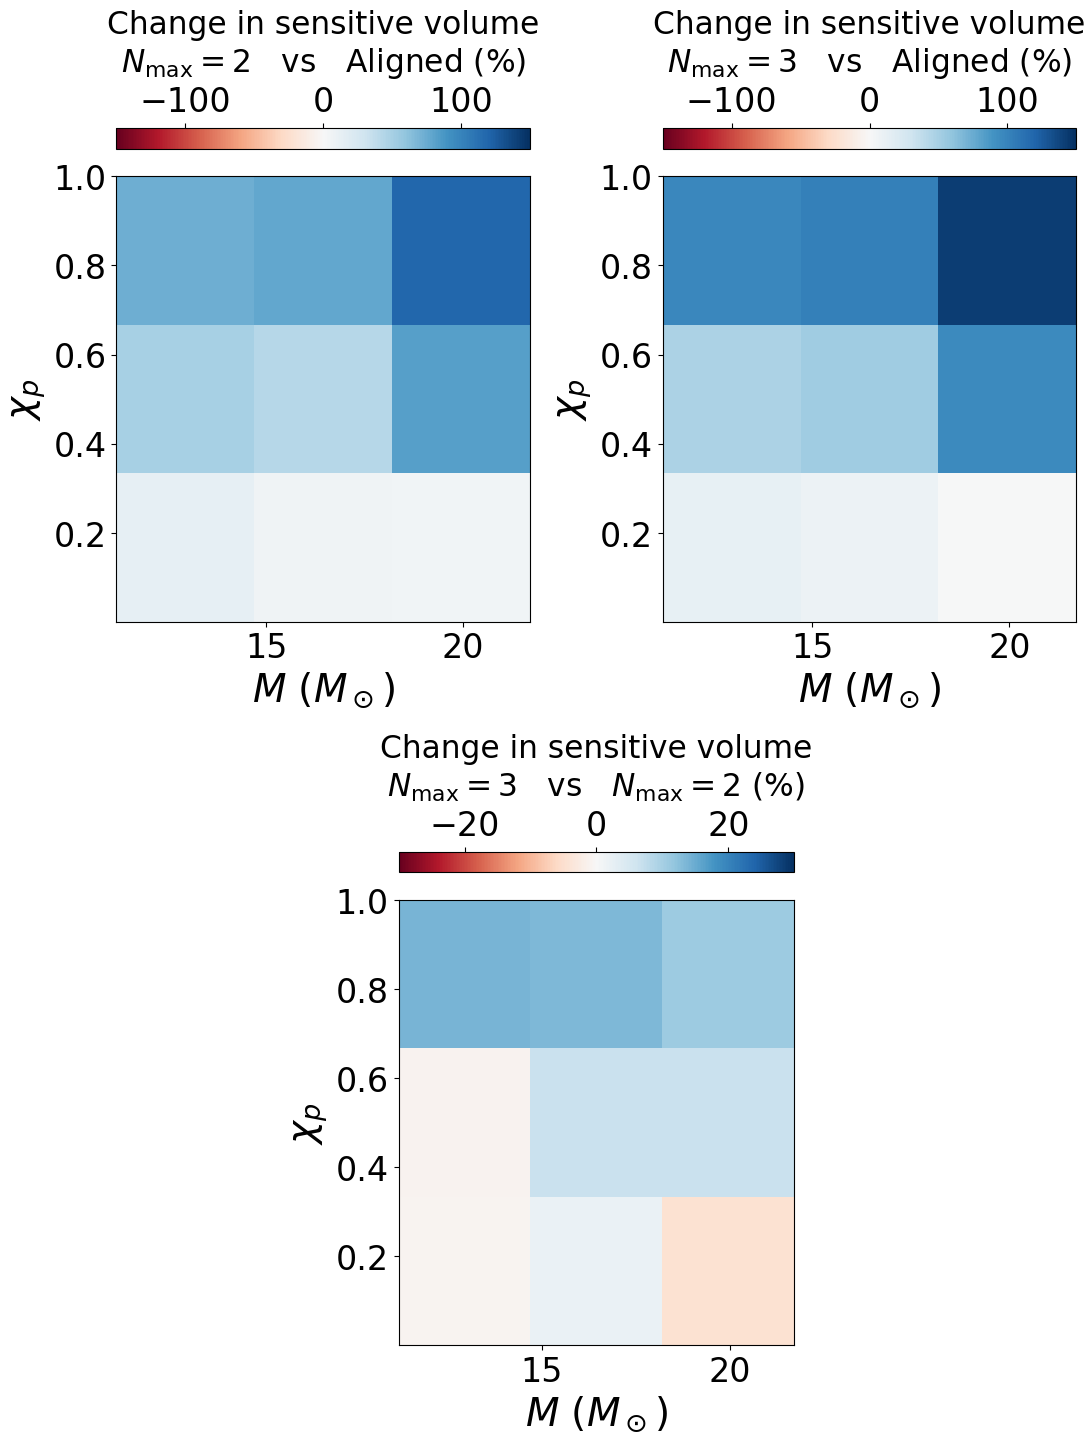

In [15]:
fig = plt.figure(figsize=(12., 16.))
gs = fig.add_gridspec(2, 1, width_ratios=[1.], height_ratios=[1., 1.],
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.32, hspace=0.3)

gst = gs[0].subgridspec(1, 2, width_ratios=[0.5, 0.5], height_ratios=[1.],
                        wspace=0.32, hspace=0.)
gsb = gs[1].subgridspec(1, 3, width_ratios=[0.25, 0.5, 0.25], height_ratios=[1.],
                        wspace=0.32, hspace=0.)

ax1 = fig.add_subplot(gst[0])
ax2 = fig.add_subplot(gst[1])
ax3 = fig.add_subplot(gsb[1])

vt_ratio = vols['prec_c2_phase'] / vols['aligned_phase']
print(vt_ratio, chip_mesh)
schange = (vt_ratio - 1) * 100
maxr = np.abs(schange).max()
if maxr > vmax:
    print(f"Warning: using vmax=100 when max change is {maxr}")

mesh1 = ax1.pcolormesh(mass_mesh, chip_mesh, schange, vmin=vmin, vmax=vmax, cmap='RdBu')
print(np.mean(schange))

vt_ratio = vols['prec_c3_phase'] / vols['aligned_phase']
print(vt_ratio, chip_mesh)
schange = (vt_ratio - 1) * 100
maxr = np.abs(schange).max()
if maxr > vmax:
    print(f"Warning: using vmax=100 when max change is {maxr}")
mesh2 = ax2.pcolormesh(mass_mesh, chip_mesh, schange, vmin=vmin, vmax=vmax, cmap='RdBu')
print(np.mean(schange))

vt_ratio = vols['prec_c3_phase'] / vols['prec_c2_phase']
print(vt_ratio, chip_mesh)
schange = (vt_ratio - 1) * 100
maxr = np.abs(schange).max()
if maxr > vmax_reduced:
    print(f"Warning: using vmax={vmax_reduced} when max change is {maxr}")
mesh3 = ax3.pcolormesh(mass_mesh, chip_mesh, schange, vmin=vmin_reduced, vmax=vmax_reduced, cmap='RdBu')
print(np.mean(schange))

ax1.set_xlabel('$M$ ($M_\odot$)', fontsize=28)
ax1.set_ylabel('$\chi_{p}$', fontsize=28)
ax1.tick_params(labelsize=24)
cbar1 = fig.colorbar(mesh1, ax=ax1, location='top')
cbar1.set_label('Change in sensitive volume\n$N_{\mathrm{max}} = 2$   vs   Aligned (%)', labelpad=10., fontsize=22.5)
cbar1.ax.tick_params(labelsize=24)

ax2.set_xlabel('$M$ ($M_\odot$)', fontsize=28)
ax2.set_ylabel('$\chi_{p}$', fontsize=28)
ax2.tick_params(labelsize=24)
cbar2 = fig.colorbar(mesh2, ax=ax2, location='top')
cbar2.set_label('Change in sensitive volume\n$N_{\mathrm{max}} = 3$   vs   Aligned (%)', labelpad=10., fontsize=22.5)
cbar2.ax.tick_params(labelsize=24)

ax3.set_xlabel('$M$ ($M_\odot$)', fontsize=28)
ax3.set_ylabel('$\chi_{p}$', fontsize=28)
ax3.tick_params(labelsize=24)
cbar3 = fig.colorbar(mesh3, ax=ax3, location='top')
cbar3.set_label('Change in sensitive volume\n$N_{\mathrm{max}} = 3$   vs   $N_{\mathrm{max}} = 2$ (%)', labelpad=10., fontsize=22.5)
cbar3.ax.tick_params(labelsize=24)

fig.savefig('phase_vt_diff.pdf', bbox_inches='tight')

## Figure 11

In [16]:
# These files are available on our data release pages
files = {
    'aligned_coinc': '/home/ian.harry/FILES_FOR_PAPER/H1L1-HDFINJFIND_NSBH_HIGHBOTH_ALIGNED_SNR_INJECTIONS-1242484974-676544.hdf',
    'aligned_phase': '/home/ian.harry/FILES_FOR_PAPER/H1L1-HDFINJFIND_NSBH_HIGHBOTH_ALIGNED_RANKSTAT_INJECTIONS-1242484974-676544.hdf',
    'prec_c2_coinc': '/home/ian.harry/FILES_FOR_PAPER/H1L1-HDFINJFIND_NSBH_HIGHBOTH_PREC2COMP_SNR_INJECTIONS-1242484974-676544.hdf',
    'prec_c2_phase': '/home/ian.harry/FILES_FOR_PAPER/H1L1-HDFINJFIND_NSBH_HIGHBOTH_PREC2COMP_RANKSTAT_INJECTIONS-1242484974-676544.hdf',
    'prec_c3_coinc': '/home/ian.harry/FILES_FOR_PAPER/H1L1-HDFINJFIND_NSBH_HIGHBOTH_PREC3COMP_SNR_INJECTIONS-1242484974-676544.hdf',
    'prec_c3_phase': '/home/ian.harry/FILES_FOR_PAPER/H1L1-HDFINJFIND_NSBH_HIGHBOTH_PREC3COMP_RANKSTAT_INJECTIONS-1242484974-676544.hdf',
}

vols = {}
errs = {}

thresh = 100.
nmass = 3
nchip = 3

mass_bins = np.linspace(11.2, 21.7, num=nmass+1, endpoint=True)
chip_bins = np.linspace(0.6, 1., num=nchip+1, endpoint=True)

mass_mesh = np.zeros((nchip, nmass), dtype=np.float32)
chip_mesh = np.zeros((nchip, nmass), dtype=np.float32)

for k, v in files.items():
    
    with h5py.File(v, 'r') as f:

        found = f['found_after_vetoes/injection_index'][:]
        missed = f['missed/after_vetoes'][:]

        mass1 = f['injections/mass1'][:]
        mass2 = f['injections/mass2'][:]
        mass = mass1 + mass2
        a1 = 2 + (3 * mass2) / (2 * mass1)
        a2 = 2 + (3 * mass1) / (2 * mass2)
        s1p = (f['injections/spin1x'][:] ** 2. + f['injections/spin1y'][:] ** 2.) ** 0.5
        s2p = (f['injections/spin2x'][:] ** 2. + f['injections/spin2y'][:] ** 2.) ** 0.5
        chip = 1 / (a1 * mass1 ** 2.) * np.maximum(a1 * s1p * mass1 ** 2., a2 * s2p * mass2 ** 2.)
        print(chip.min(), chip.max())
        
        dist = f['injections/distance'][:]
        print(f"distance: {dist.min():.2f} -> {dist.max():.2f}")

        ifar_exc = f['found_after_vetoes/ifar_exc'][:]
        t = f.attrs['foreground_time_exc'] / lal_YRJUL_SI

    quiet = found[ifar_exc < thresh]
    missed = np.concatenate([missed, quiet])
    found = found[ifar_exc >= thresh]

    missed_dist = dist[missed]
    found_dist = dist[found]

    missed_mass = mass[missed]
    found_mass = mass[found]
    
    missed_chip = chip[missed]
    found_chip = chip[found]

    vol = np.zeros((nchip, nmass), dtype=np.float32)
    err = np.zeros((nchip, nmass), dtype=np.float32)

    for i in range(len(mass_bins) - 1):
        mlow = mass_bins[i]
        mhigh = mass_bins[i+1]
        for j in range(len(chip_bins) - 1):
            clow = chip_bins[j]
            chigh = chip_bins[j+1]
            missed_lgc = (missed_mass > mlow) & (missed_mass <= mhigh) & (missed_chip > clow) & (missed_chip <= chigh)
            found_lgc = (found_mass > mlow) & (found_mass <= mhigh) & (found_chip > clow) & (found_chip <= chigh)
    
            missed_dist_bin = missed_dist[missed_lgc]
            found_dist_bin = found_dist[found_lgc]

            v, e = volume_binned_pylal(found_dist_bin, missed_dist_bin, bins=50)
            vol[j, i] = v
            err[j, i] = e
            
            mass_mesh[j, i] = (mlow + mhigh) / 2.
            chip_mesh[j, i] = (clow + chigh) / 2.
    
    vols[k] = vol
    errs[k] = err

0.6692015806785456 0.9897126824295699
distance: 1.68 -> 290.47
0.6692015806785456 0.9897126824295699
distance: 1.68 -> 290.47
0.6692015806785456 0.9897126824295699
distance: 1.68 -> 290.47
0.6692015806785456 0.9897126824295699
distance: 1.68 -> 290.47
0.6692015806785456 0.9897126824295699
distance: 1.68 -> 290.47
0.6692015806785456 0.9897126824295699
distance: 1.68 -> 290.47


[[1.5403168 1.8804876 1.6065083]
 [1.703347  2.1958764 1.9867226]
 [1.7654036 1.8593735 1.9047189]] [[0.6666667  0.6666667  0.6666667 ]
 [0.8        0.8        0.8       ]
 [0.93333334 0.93333334 0.93333334]]
0.6666667 82.69727
[[1.6065733 1.9004574 1.7222289]
 [1.8403904 2.3051085 2.0355573]
 [1.7882128 1.9607774 2.1351497]] [[0.6666667  0.6666667  0.6666667 ]
 [0.8        0.8        0.8       ]
 [0.93333334 0.93333334 0.93333334]]
0.6666667 92.160614
[[1.0430149 1.0106195 1.0720323]
 [1.0804554 1.0497441 1.0245805]
 [1.0129201 1.0545367 1.120979 ]] [[0.6666667  0.6666667  0.6666667 ]
 [0.8        0.8        0.8       ]
 [0.93333334 0.93333334 0.93333334]]
0.6666667 5.209806


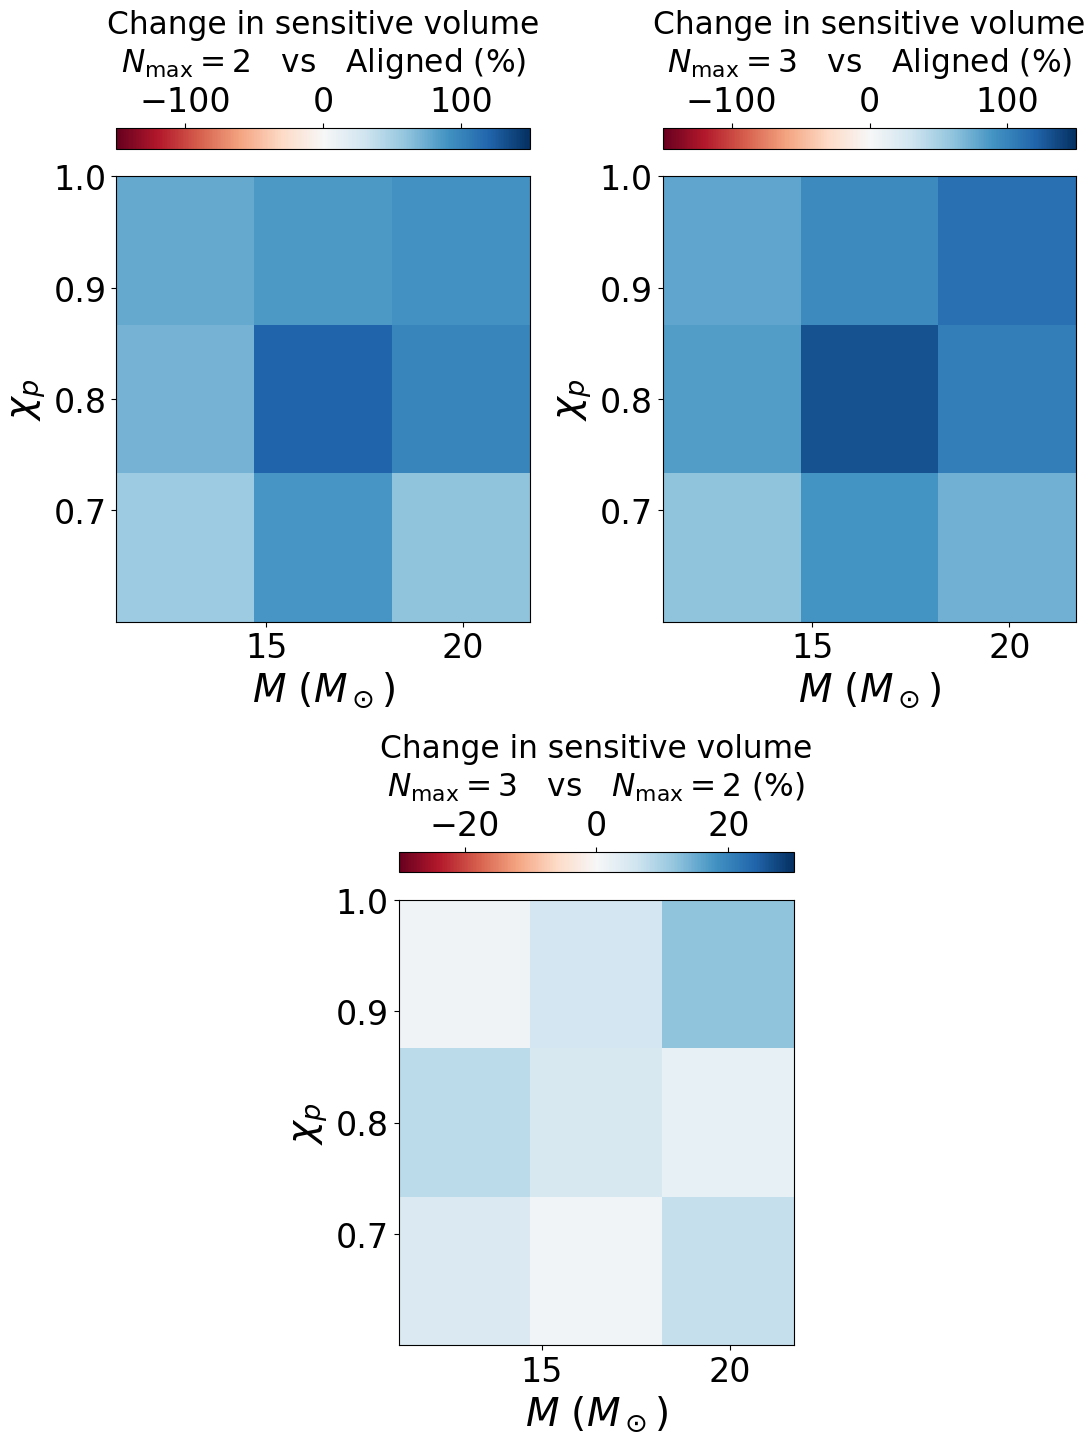

In [17]:
fig = plt.figure(figsize=(12., 16.))
gs = fig.add_gridspec(2, 1, width_ratios=[1.], height_ratios=[1., 1.],
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.32, hspace=0.3)

gst = gs[0].subgridspec(1, 2, width_ratios=[0.5, 0.5], height_ratios=[1.],
                        wspace=0.32, hspace=0.)
gsb = gs[1].subgridspec(1, 3, width_ratios=[0.25, 0.5, 0.25], height_ratios=[1.],
                        wspace=0.32, hspace=0.)

ax1 = fig.add_subplot(gst[0])
ax2 = fig.add_subplot(gst[1])
ax3 = fig.add_subplot(gsb[1])

vt_ratio = vols['prec_c2_phase'] / vols['aligned_phase']
print(vt_ratio, chip_mesh)
schange = (vt_ratio - 1) * 100
maxr = np.abs(schange).max()
if maxr > vmax:
    print(f"Warning: using vmax={vaxm} when max change is {maxr}")
mesh1 = ax1.pcolormesh(mass_mesh, chip_mesh, schange, vmin=vmin, vmax=vmax, cmap='RdBu')
print(np.min(chip_mesh), np.mean(schange))

vt_ratio = vols['prec_c3_phase'] / vols['aligned_phase']
print(vt_ratio, chip_mesh)
schange = (vt_ratio - 1) * 100
maxr = np.abs(schange).max()
if maxr > vmax:
    print(f"Warning: using vmax={vaxm} when max change is {maxr}")
mesh2 = ax2.pcolormesh(mass_mesh, chip_mesh, schange, vmin=vmin, vmax=vmax, cmap='RdBu')
print(np.min(chip_mesh), np.mean(schange))

vt_ratio = vols['prec_c3_phase'] / vols['prec_c2_phase']
print(vt_ratio, chip_mesh)
schange = (vt_ratio - 1) * 100
maxr = np.abs(schange).max()
if maxr > vmax_reduced:
    print(f"Warning: using vmax={vmax_reduced} when max change is {maxr}")
mesh3 = ax3.pcolormesh(mass_mesh, chip_mesh, schange, vmin=vmin_reduced, vmax=vmax_reduced, cmap='RdBu')
print(np.min(chip_mesh), np.mean(schange))

ax1.set_xlabel('$M$ ($M_\odot$)', fontsize=28)
ax1.set_ylabel('$\chi_{p}$', fontsize=28)
ax1.tick_params(labelsize=24)
cbar1 = fig.colorbar(mesh1, ax=ax1, location='top')
cbar1.set_label('Change in sensitive volume\n$N_{\mathrm{max}} = 2$   vs   Aligned (%)', labelpad=10., fontsize=22.5)
cbar1.ax.tick_params(labelsize=24)

ax2.set_xlabel('$M$ ($M_\odot$)', fontsize=28)
ax2.set_ylabel('$\chi_{p}$', fontsize=28)
ax2.tick_params(labelsize=24)
cbar2 = fig.colorbar(mesh2, ax=ax2, location='top')
cbar2.set_label('Change in sensitive volume\n$N_{\mathrm{max}} = 3$   vs   Aligned (%)', labelpad=10., fontsize=22.5)
cbar2.ax.tick_params(labelsize=24)

ax3.set_xlabel('$M$ ($M_\odot$)', fontsize=28)
ax3.set_ylabel('$\chi_{p}$', fontsize=28)
ax3.tick_params(labelsize=24)
cbar3 = fig.colorbar(mesh3, ax=ax3, location='top')
cbar3.set_label('Change in sensitive volume\n$N_{\mathrm{max}} = 3$   vs   $N_{\mathrm{max}} = 2$ (%)', labelpad=10., fontsize=22.5)
cbar3.ax.tick_params(labelsize=24)

fig.savefig('phase_vt_diff_high_both.pdf', bbox_inches='tight')

## Figure 12

In [8]:
from pycbc.conversions import chi_p
params = {
    "mass1": 13.4239,
    "mass2": 1.31179,
    "spin1x": 0.000333624,
    "spin1y": -0.000180359,
    "spin1z": -0.483778,
    "spin2x": -0.0240528,
    "spin2y": -0.104305,
    "spin2z": -0.195768,
    "inclination": 2*np.pi - 4.79938,
    "coa_phase": 4.9661,
    "f_lower": 30.
}
print(
    f"chi_p = {chi_p(params['mass1'], params['mass2'], params['spin1x'], params['spin1y'], params['spin2x'], params['spin2y'])}"
)

chi_p = 0.008261840276878504


In [9]:
hp, hc = get_fd_waveform(
    approximant="IMRPhenomXP", **params, delta_f=1./256
)
xp = hp.to_timeseries()
xp = xp.cyclic_time_shift(-1.)

_params = params.copy()
_params["spin1x"] = 0.
_params["spin1y"] = 0.
_params["spin2x"] = 0.
_params["spin2y"] = 0.
_hp, _hc = get_fd_waveform(
    approximant="IMRPhenomXAS", **_params, delta_f=1./256
)
xas = _hp.to_timeseries()
xas = xas.cyclic_time_shift(-1.)

In [10]:
template = PhenomXPTemplateAlt(
    params["mass1"], params["mass2"], params["spin1x"], params["spin1y"], params["spin1z"],
    params["spin2x"], params["spin2y"], params["spin2z"], 1./2048, 20.
)
harmonics = template.compute_waveform_five_comps(xp.delta_f, 1024., interp=False)

In [11]:
eob, _ = get_td_waveform(
    approximant="SEOBNRv4P", **params, delta_t=1./2048
)
eobf = eob.to_frequencyseries()

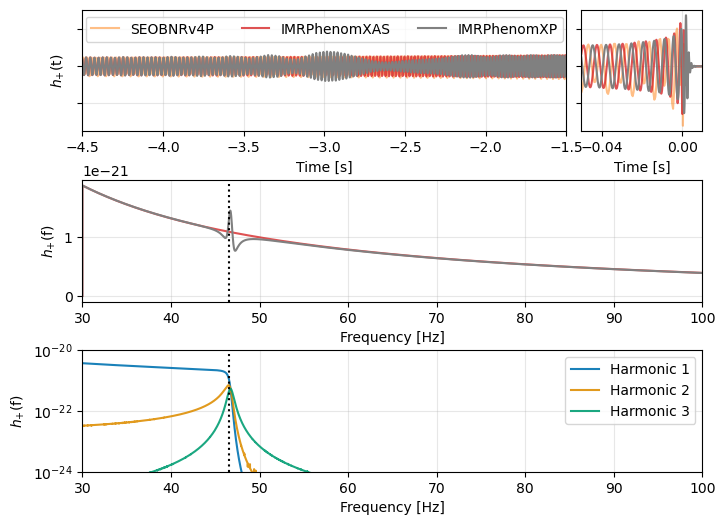

In [13]:
fig = plt.figure(figsize=(8, 6))
gs = GridSpec(nrows=3, ncols=2, width_ratios=[4,1])
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
ax2 = fig.add_subplot(gs[1,:])
ax3 = fig.add_subplot(gs[2,:])
axs = [ax0, ax1, ax2, ax3]
axs[0].plot(eob.sample_times, eob, color='tab:orange', alpha=0.5, label="SEOBNRv4P")
axs[0].plot(xas.sample_times, xas, color='tab:red', alpha=0.8, linestyle="-", label="IMRPhenomXAS")
axs[0].plot(xp.sample_times, xp, color='grey', label="IMRPhenomXP")
axs[0].set_xlabel(r"Time [s]")
axs[0].set_ylabel(r"$h_{+}$(t)")
axs[0].grid(alpha=0.3)
axs[0].set_xlim([-4.5, -1.5])
axs[0].legend(loc="upper center", ncols=3)

axs[1].plot(eob.sample_times, eob, color='tab:orange', alpha=0.5)
axs[1].plot(xas.sample_times, xas, color='tab:red', alpha=0.8, linestyle="-")
axs[1].plot(xp.sample_times, xp, color='grey')
axs[1].grid(alpha=0.3)
axs[1].set_xlabel(r"Time [s]")
axs[1].set_yticklabels([])
axs[1].set_xticks([-0.04, 0.0])
axs[1].set_xlim([-0.05, 0.01])

#axs[2].plot(eobf.sample_frequencies, np.abs(eobf), color='tab:orange', alpha=0.5)
axs[2].plot(_hp.sample_frequencies, np.abs(_hp), color='tab:red', alpha=0.8, linestyle="-")
axs[2].plot(hp.sample_frequencies, np.abs(hp), color='grey')
axs[2].axvline(46.5, color='k', linestyle=":")
axs[2].set_xlabel(r"Frequency [Hz]")
axs[2].set_ylabel(r"$h_{+}$(f)")
axs[2].grid(alpha=0.3)
axs[2].set_xlim([30, 100])

for ii in range(3):
    h = harmonics[ii]
    axs[3].plot(h.sample_frequencies, np.abs(h), color=harmonic_colors[ii], label=f"Harmonic {ii + 1}", alpha=0.9)
axs[3].set_xlim([30, 100])
axs[3].set_xticks([30, 40, 50, 60, 70, 80, 90, 100])
axs[3].set_yscale("log")
_, yhigh = axs[2].get_ylim()
axs[3].set_ylim([1e-24, 1e-20])
axs[3].grid(alpha=0.3)
axs[3].legend()
axs[3].axvline(46.5, color='k', linestyle=":")
axs[3].set_ylabel(r"$h_{+}$(f)")
axs[3].set_xlabel(r"Frequency [Hz]")
plt.subplots_adjust(wspace=0.05, hspace=0.4)
plt.savefig("waveform_inconsistency.pdf")